<center><h1>New York City Taxi Fare Prediction</h1>
    <h3>Projet Big Data</h3>
<h6>Flora Fevrier / Gabriel Foret / Paul Debuire / Alban Daniel / Solène Lemas</h6></center>
<hr/>

In [344]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import des packages

In [345]:
import pandas as pd
from geopy.distance import geodesic
import math
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, MultiPolygon, Polygon
import holidays
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
import seaborn as sb
from datetime import datetime, timedelta
import pytz

# Import des données

In [346]:
# Import des trajets de taxis

taxi_test = pd.read_csv('/content/drive/MyDrive/Projet BIG DATA/train.csv', sep = ',', nrows=10000)

In [347]:
taxi_test.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [348]:
#dimensions
print("\n", taxi_test.shape[0], " individus et ", taxi_test.shape[1], " variables.")


 10000  individus et  8  variables.


In [349]:
# Import des monuments

monuments = pd.read_csv('/content/drive/MyDrive/Projet BIG DATA/monuments.csv', sep = ';')
monuments.head()

,Monument,Longitude,Latitude
0,JFK Airport,-73.780526,40.648823
1,LaGuardia Airport,-73.875195,40.779340
2,Empire State Building,-73.985796,40.750383
3,Times Square,-73.985781,40.758863
4,Dumbo,-73.989523,40.703502


In [350]:
# Import des données des quartiers de New York

lieux = gpd.read_file('/content/drive/MyDrive/Projet BIG DATA/lieux.csv', sep = '\t')
lieux.head()

,Quartier,Longitude,Latitude,geometry
0,Manhattan,-74.0166124034476,40.70179571338421,None
1,Manhattan,-74.00974594853915,40.74992969056441,None
2,Manhattan,-73.92494522953764,40.87803019206632,None
3,Manhattan,-73.9070924467757,40.87309783890215,None
4,Manhattan,-73.9335282981732,40.834924581835416,None


In [351]:
# Import des délimitations de la ville de New York

delimitation = pd.read_csv('/content/drive/MyDrive/Projet BIG DATA/delimitations.csv', sep = ';')
delimitation.head()

,Longitude,Latitude
0,-74.256349,40.491646
1,-74.247366,40.543321
2,-74.226489,40.556233
3,-74.212894,40.556787
4,-74.200513,40.631813


# Traitement des données manquantes et valeurs aberrantes

In [352]:
# nombre de NA par colonne
pd.isna(taxi_test).sum()
# 376 lignes avec données manquantes soit moins de 0,01 % de notre train

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [353]:
# suppression des lignes avec données manquantes : courses non terminées
taxi_test = taxi_test.dropna()

In [354]:
#dimensions
print("\n", taxi_test.shape[0], " individus et ", taxi_test.shape[1], " variables.")


 10000  individus et  8  variables.


In [355]:
# Convertissez la colonne pickup_datetime en type datetime si ce n'est pas déjà fait
taxi_test['pickup_datetime'] = pd.to_datetime(taxi_test['pickup_datetime'])

# Définissez le fuseau horaire de destination (New York)
destination_timezone = pytz.timezone('America/New_York')

# Convertissez l'heure de pickup_datetime à l'heure de New York
taxi_test['pickup_datetime_ny'] = taxi_test['pickup_datetime'].dt.tz_convert(destination_timezone)

# Puis suppression de l'ancienne pickup_datetime
taxi_test = taxi_test.drop('pickup_datetime', axis=1)

In [356]:
# variable pickup_datetime_ny
# on récupère que la date
taxi_test['datedep']=taxi_test['pickup_datetime_ny'].dt.date

In [357]:
taxi_test['datedep'] = pd.to_datetime(taxi_test['datedep'], errors='coerce')

In [358]:
# on vérifie si données manquantes = mauvaise conversion donc mauvaise date
donnees_aberrantes = taxi_test[taxi_test['datedep'].isnull()]

In [359]:
donnees_aberrantes.shape

(0, 9)

In [360]:
taxi_test.head()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_ny,datedep
0,2009-06-15 17:26:21.0000001,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009-06-15 13:26:21-04:00,2009-06-15
1,2010-01-05 16:52:16.0000002,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010-01-05 11:52:16-05:00,2010-01-05
2,2011-08-18 00:35:00.00000049,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011-08-17 20:35:00-04:00,2011-08-17
3,2012-04-21 04:30:42.0000001,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012-04-21 00:30:42-04:00,2012-04-21
4,2010-03-09 07:51:00.000000135,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010-03-09 02:51:00-05:00,2010-03-09


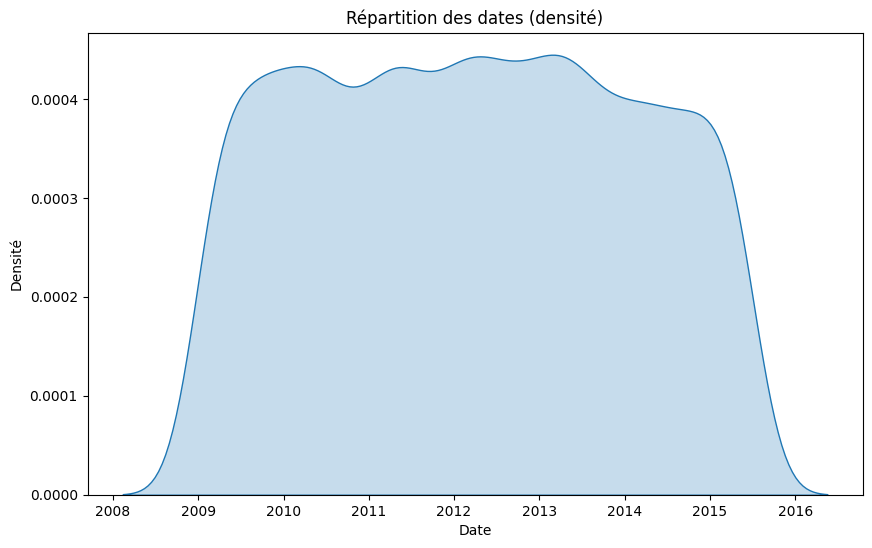

In [361]:
# graphique
plt.figure(figsize=(10, 6))
sb.kdeplot(taxi_test['datedep'], fill=True)
plt.title('Répartition des dates (densité)')
plt.xlabel('Date')
plt.ylabel('Densité')
plt.show()

In [362]:
#dimensions
print("\n", taxi_test.shape[0], " individus et ", taxi_test.shape[1], " variables.")


 10000  individus et  9  variables.


In [363]:
#variable Pickup_latitude
#la latitude est comprise entre [-90;90] : on supprime les valeurs en dehors de cette intervalle
cond=(taxi_test['pickup_latitude']<=90) & (taxi_test['pickup_latitude']>-90)
taxi_test.drop(taxi_test[~cond].index, inplace=True)

In [364]:
#suppression des latitudes à 0
cond=(taxi_test['pickup_latitude']>=1) | (taxi_test['pickup_latitude']<=-1)
taxi_test.drop(taxi_test[~cond].index, inplace=True)

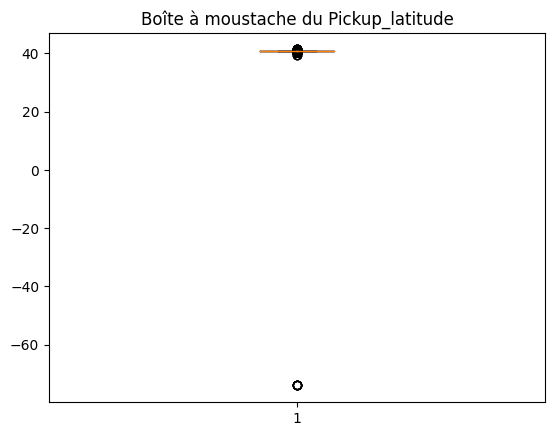

In [365]:
#graphique
plt.boxplot(taxi_test.pickup_latitude)
plt.title("Boîte à moustache du Pickup_latitude")
plt.show()

In [366]:
#dimensions
print("\n", taxi_test.shape[0], " individus et ", taxi_test.shape[1], " variables.")


 9806  individus et  9  variables.


In [367]:
#variable Dropoff_latitude
#la latitude est comprise entre [-90;90] : on supprime les valeurs en dehors de cette intervalle
cond=(taxi_test['dropoff_latitude']<=90) & (taxi_test['dropoff_latitude']>-90)
taxi_test.drop(taxi_test[~cond].index, inplace=True)

In [368]:
#suppression des latitudes à 0
cond=(taxi_test['pickup_latitude']>=1) | (taxi_test['pickup_latitude']<=-1)
taxi_test.drop(taxi_test[~cond].index, inplace=True)

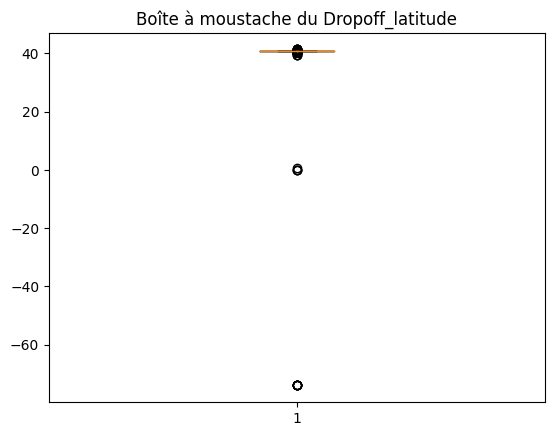

In [369]:
#graphique
plt.boxplot(taxi_test.dropoff_latitude)
plt.title("Boîte à moustache du Dropoff_latitude")
plt.show()

In [370]:
#dimensions
print("\n", taxi_test.shape[0], " individus et ", taxi_test.shape[1], " variables.")


 9806  individus et  9  variables.


In [371]:
#variable Pickup_longitude
#la longitude est comprise entre [-180;180] : on supprime les valeurs en dehors de cette intervalle
cond=(taxi_test['pickup_longitude']<=180) & (taxi_test['pickup_longitude']>=-180)
taxi_test.drop(taxi_test[~cond].index, inplace=True)

In [372]:
#suppression des latitudes à 0
cond=(taxi_test['pickup_latitude']>=1) | (taxi_test['pickup_latitude']<=-1)
taxi_test.drop(taxi_test[~cond].index, inplace=True)

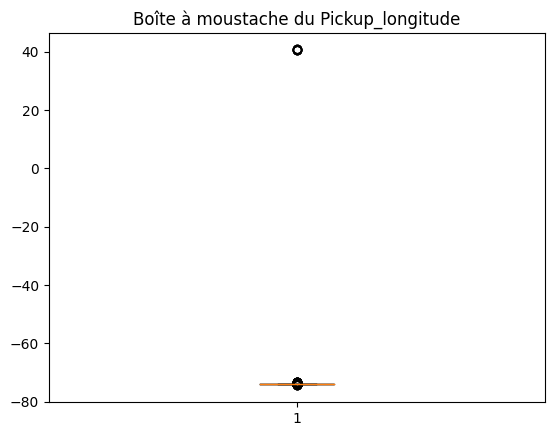

In [373]:
#graphique
plt.boxplot(taxi_test.pickup_longitude)
plt.title("Boîte à moustache du Pickup_longitude")
plt.show()

In [374]:
#dimensions
print("\n", taxi_test.shape[0], " individus et ", taxi_test.shape[1], " variables.")


 9806  individus et  9  variables.


In [375]:
#variable Dropoff_longitude
#la longitude est comprise entre [-180;180] : on supprime les valeurs en dehors de cette intervalle
cond=(taxi_test['dropoff_longitude']<=180) & (taxi_test['dropoff_longitude']>=-180)
taxi_test.drop(taxi_test[~cond].index, inplace=True)

In [376]:
#suppression des latitudes à 0
cond=(taxi_test['pickup_latitude']>=1) | (taxi_test['pickup_latitude']<=-1)
taxi_test.drop(taxi_test[~cond].index, inplace=True)

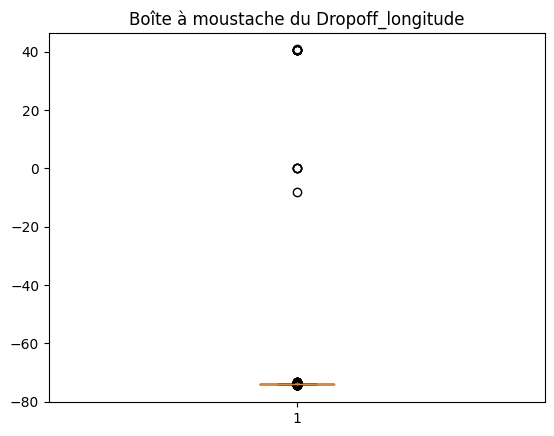

In [377]:
#graphique
plt.boxplot(taxi_test.dropoff_longitude)
plt.title("Boîte à moustache du Dropoff_longitude")
plt.show()

In [378]:
#dimensions
print("\n", taxi_test.shape[0], " individus et ", taxi_test.shape[1], " variables.")


 9806  individus et  9  variables.


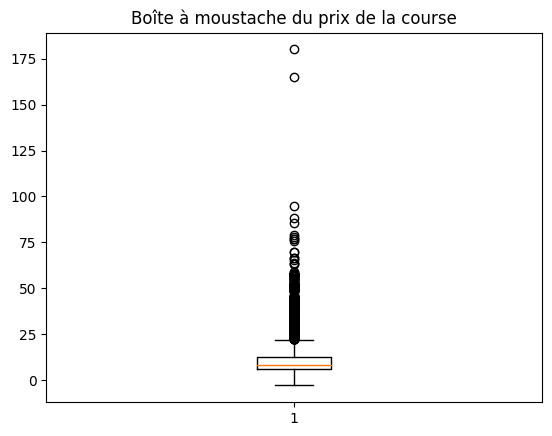

In [379]:
# données aberrantes de la variable fare_amount
plt.boxplot(taxi_test.fare_amount)
plt.title("Boîte à moustache du prix de la course")
plt.show()
#données aberrantes

In [380]:
# on supprime les lignes qui ont un prix de course négatif
taxi_test.drop(taxi_test[taxi_test['fare_amount']<0].index,inplace=True)

In [381]:
# on détermine le prix max d'une course pour 99% des individus
bornesup = taxi_test['fare_amount'].quantile(0.99)

In [382]:
# on supprime les lignes qui ont un prix supérieur à cette borne
taxi_test.drop(taxi_test[taxi_test['fare_amount']>bornesup].index,inplace=True)

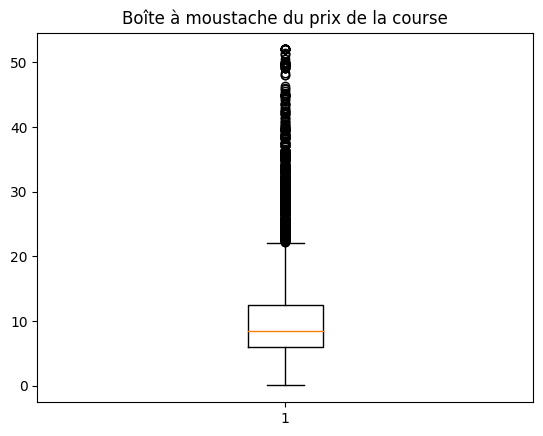

In [383]:
plt.boxplot(taxi_test.fare_amount)
plt.title("Boîte à moustache du prix de la course")
plt.show()

In [384]:
#dimensions
print("\n", taxi_test.shape[0], " individus et ", taxi_test.shape[1], " variables.")


 9705  individus et  9  variables.


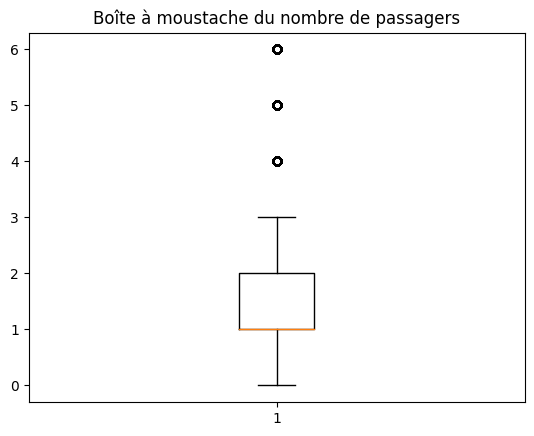

In [385]:
# variable Passenger_count
plt.boxplot(taxi_test.passenger_count)
plt.title("Boîte à moustache du nombre de passagers")
plt.show()
#données aberrantes

In [386]:
#on supprime les lignes où le nombre de passagers est supérieur à 8 (un van a 9 places)
taxi_test.drop(taxi_test[taxi_test['passenger_count']>8].index,inplace=True)

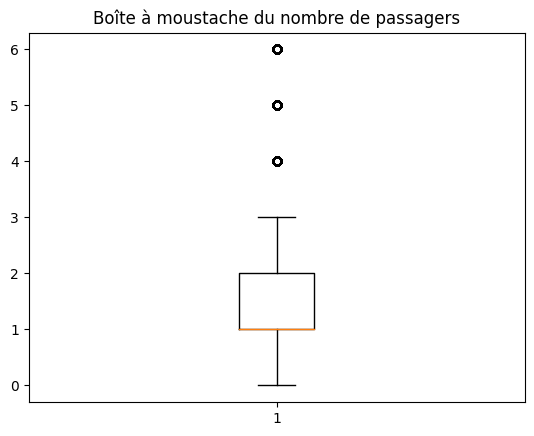

In [387]:
plt.boxplot(taxi_test.passenger_count)
plt.title("Boîte à moustache du nombre de passagers")
plt.show()

In [388]:
#dimensions
print("\n", taxi_test.shape[0], " individus et ", taxi_test.shape[1], " variables.")


 9705  individus et  9  variables.


# Feature Engineering

In [389]:
# Calcul de la distance de Manhattan entre les 4 variables de coordonnées

taxi_test['manhattan_distance_km'] = taxi_test.apply(lambda row: geodesic((row['pickup_latitude'], row['pickup_longitude']),
                                                            (row['dropoff_latitude'], row['pickup_longitude'])).kilometers +
                                               geodesic((row['dropoff_latitude'], row['pickup_longitude']),
                                                            (row['dropoff_latitude'], row['dropoff_longitude'])).kilometers, axis=1)

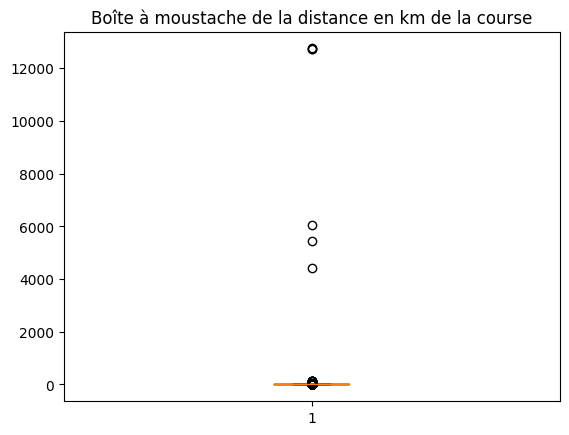

In [390]:
# On regarde si présence de données aberrantes dans la nouvelle variable manhattan_distance_km
plt.boxplot(taxi_test.manhattan_distance_km)
plt.title("Boîte à moustache de la distance en km de la course")
plt.show()
# données aberrantes ? (valeurs trop importantes en km)

In [391]:
# on détermine la distance max d'une course pour 99% des individus
bornesup = taxi_test['manhattan_distance_km'].quantile(0.99)

In [392]:
# on supprime les lignes qui ont un prix supérieur à cette borne
taxi_test.drop(taxi_test[taxi_test['manhattan_distance_km']>bornesup].index,inplace=True)

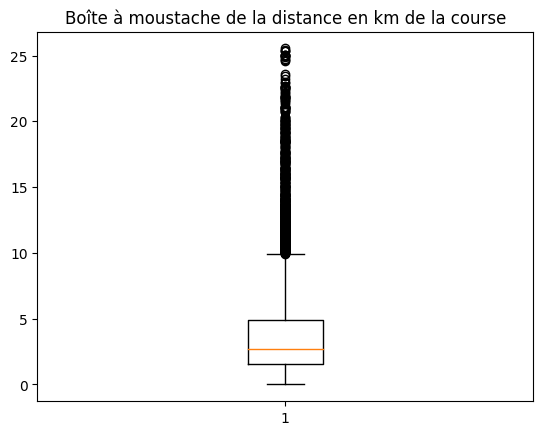

In [393]:
# Vérification
plt.boxplot(taxi_test.manhattan_distance_km)
plt.title("Boîte à moustache de la distance en km de la course")
plt.show()

In [394]:
# Création des classes de distances également réparties de la variable 'manhattan_distance_km'

# Utiliser qcut pour découper en 5 classes

taxi_test['distance_classe_manhattan_kms'], bins = pd.qcut(taxi_test['manhattan_distance_km'], q=5, labels=False, retbins=True)

# Créer des noms de classe basés sur les intervalles

class_names = [f'[{round(bins[i], 2)}; {round(bins[i+1], 2)}[' for i in range(len(bins)-1)]
class_names.append(f'[{round(bins[-1], 2)}; inf[')

# Attribuer les noms de classe à la variable 'distance_classe'

taxi_test['distance_classe_manhattan_kms'] = taxi_test['distance_classe_manhattan_kms'].apply(lambda x: class_names[x])

# Suppression de la variable de distance

taxi_test.drop("manhattan_distance_km", axis=1, inplace=True)

taxi_test.head()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_ny,datedep,distance_classe_manhattan_kms
0,2009-06-15 17:26:21.0000001,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009-06-15 13:26:21-04:00,2009-06-15,[0.0; 1.37[
1,2010-01-05 16:52:16.0000002,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010-01-05 11:52:16-05:00,2010-01-05,[5.65; 25.53[
2,2011-08-18 00:35:00.00000049,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011-08-17 20:35:00-04:00,2011-08-17,[1.37; 2.2[
3,2012-04-21 04:30:42.0000001,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012-04-21 00:30:42-04:00,2012-04-21,[2.2; 3.39[
4,2010-03-09 07:51:00.000000135,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010-03-09 02:51:00-05:00,2010-03-09,[2.2; 3.39[


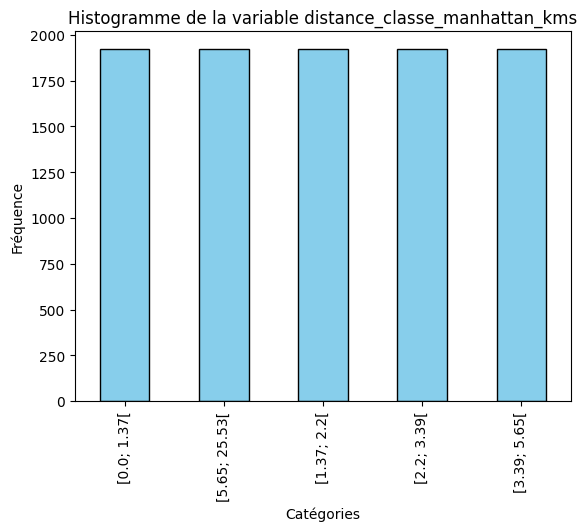

In [395]:
# Vérification de la bonne distribution de la nouvelle variable de classe
taxi_test['distance_classe_manhattan_kms'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')

plt.title("Histogramme de la variable distance_classe_manhattan_kms")
plt.xlabel("Catégories")
plt.ylabel("Fréquence")
plt.show()

In [396]:
# Création de la variable 'type_vehicule'

taxi_test['type_vehicule'] = ['Voiture' if int(count) < 5 else 'Van' for count in taxi_test['passenger_count']]

In [397]:
taxi_test.head()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_ny,datedep,distance_classe_manhattan_kms,type_vehicule
0,2009-06-15 17:26:21.0000001,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009-06-15 13:26:21-04:00,2009-06-15,[0.0; 1.37[,Voiture
1,2010-01-05 16:52:16.0000002,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010-01-05 11:52:16-05:00,2010-01-05,[5.65; 25.53[,Voiture
2,2011-08-18 00:35:00.00000049,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011-08-17 20:35:00-04:00,2011-08-17,[1.37; 2.2[,Voiture
3,2012-04-21 04:30:42.0000001,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012-04-21 00:30:42-04:00,2012-04-21,[2.2; 3.39[,Voiture
4,2010-03-09 07:51:00.000000135,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010-03-09 02:51:00-05:00,2010-03-09,[2.2; 3.39[,Voiture


In [398]:
# Convertir les DataFrames en GeoDataFrames
gdf_taxi = gpd.GeoDataFrame(taxi_test,
                            geometry=gpd.points_from_xy(taxi_test['pickup_longitude'], taxi_test['pickup_latitude']))
gdf_lieux = gpd.GeoDataFrame(lieux,
                             geometry=gpd.points_from_xy(lieux['Longitude'], lieux['Latitude']))

# Créer une fonction pour obtenir le quartier correspondant
def get_quartier(point):
    if point.x == 0.0 and point.y == 0.0:
        return 'Autre'

    nearest_quartier = gdf_lieux['Quartier'].iloc[gdf_lieux.distance(point).idxmin()]
    return 'Hors de New York' if pd.isnull(nearest_quartier) else nearest_quartier

# Créer une colonne 'quartier_depart' dans gdf_taxi
gdf_taxi['quartier_depart'] = gdf_taxi['geometry'].apply(get_quartier)

# Répéter le processus pour le lieu d'arrivée
gdf_taxi['quartier_arrivee'] = gdf_taxi['geometry'].apply(get_quartier)

# Supprimer la colonne 'geometry' si vous ne la voulez plus
gdf_taxi = gdf_taxi.drop('geometry', axis=1)

# Ajouter ces informations à votre DataFrame d'origine
taxi_test['quartier_depart'] = gdf_taxi['quartier_depart']
taxi_test['quartier_arrivee'] = gdf_taxi['quartier_arrivee']

In [399]:
taxi_test.head()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_ny,datedep,distance_classe_manhattan_kms,type_vehicule,quartier_depart,quartier_arrivee
0,2009-06-15 17:26:21.0000001,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009-06-15 13:26:21-04:00,2009-06-15,[0.0; 1.37[,Voiture,Queens,Queens
1,2010-01-05 16:52:16.0000002,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010-01-05 11:52:16-05:00,2010-01-05,[5.65; 25.53[,Voiture,Manhattan,Manhattan
2,2011-08-18 00:35:00.00000049,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011-08-17 20:35:00-04:00,2011-08-17,[1.37; 2.2[,Voiture,Manhattan,Manhattan
3,2012-04-21 04:30:42.0000001,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012-04-21 00:30:42-04:00,2012-04-21,[2.2; 3.39[,Voiture,Manhattan,Manhattan
4,2010-03-09 07:51:00.000000135,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010-03-09 02:51:00-05:00,2010-03-09,[2.2; 3.39[,Voiture,Queens,Queens


In [400]:
# Convertissez 'monuments' en GeoDataFrame
gdf_monuments = gpd.GeoDataFrame(monuments,
                                 geometry=gpd.points_from_xy(monuments['Longitude'], monuments['Latitude']))

# Créez des colonnes dans votre DataFrame d'origine 'taxi_test' pour les distances aux monuments de départ et d'arrivée
taxi_test['geometry_depart'] = taxi_test.apply(lambda row: Point(row['pickup_latitude'], row['pickup_longitude']), axis=1)
taxi_test['geometry_arrivee'] = taxi_test.apply(lambda row: Point(row['dropoff_latitude'], row['dropoff_longitude']), axis=1)

# Créez une fonction pour calculer la distance
def calculate_distance(point, geometry_series):
    return min(geodesic(point.coords[0], geometry.coords[0]).meters for geometry in geometry_series)

# Appliquez la fonction pour les lieux de départ et d'arrivée
taxi_test['distance_depart_monument'] = taxi_test['geometry_depart'].apply(lambda point: calculate_distance(point, gdf_monuments['geometry']))
taxi_test['distance_arrivee_monument'] = taxi_test['geometry_arrivee'].apply(lambda point: calculate_distance(point, gdf_monuments['geometry']))

# Ajoutez une colonne binaire indiquant si la distance est inférieure à 500 mètres
taxi_test['proximite_depart_monument'] = taxi_test['distance_depart_monument'] < 500
taxi_test['proximite_arrivee_monument'] = taxi_test['distance_arrivee_monument'] < 500

# Supprimez les colonnes de géométrie
taxi_test = taxi_test.drop(['geometry_depart', 'geometry_arrivee'], axis=1)

# Convertir les valeurs True/False en 1/0
taxi_test['proximite_depart_monument'] = taxi_test['proximite_depart_monument'].astype(int)
taxi_test['proximite_arrivee_monument'] = taxi_test['proximite_arrivee_monument'].astype(int)

# Supprimer les colonnes de distances
taxi_test = taxi_test.drop(['distance_depart_monument', 'distance_arrivee_monument'], axis=1)

In [401]:
taxi_test.head()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_ny,datedep,distance_classe_manhattan_kms,type_vehicule,quartier_depart,quartier_arrivee,proximite_depart_monument,proximite_arrivee_monument
0,2009-06-15 17:26:21.0000001,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009-06-15 13:26:21-04:00,2009-06-15,[0.0; 1.37[,Voiture,Queens,Queens,0,0
1,2010-01-05 16:52:16.0000002,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010-01-05 11:52:16-05:00,2010-01-05,[5.65; 25.53[,Voiture,Manhattan,Manhattan,0,0
2,2011-08-18 00:35:00.00000049,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011-08-17 20:35:00-04:00,2011-08-17,[1.37; 2.2[,Voiture,Manhattan,Manhattan,0,0
3,2012-04-21 04:30:42.0000001,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012-04-21 00:30:42-04:00,2012-04-21,[2.2; 3.39[,Voiture,Manhattan,Manhattan,0,0
4,2010-03-09 07:51:00.000000135,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010-03-09 02:51:00-05:00,2010-03-09,[2.2; 3.39[,Voiture,Queens,Queens,0,0


In [402]:
def moment_journee(heure):
    """
    Fonction permettant de récupérer le moment de la journée en fonction d'une heure passée en paramètre
    Parameters
    ----------
    heure : int (heure de la journée dont ou souhaite récupérer le moment)
    """
    if heure>=5 and heure<12 :
        return("Matin")
    elif heure>=12 and heure<14 :
        return('Midi')
    elif heure>=14 and heure<18 :
        return("Après-midi")
    elif heure>=18 and heure<21 :
        return('Soir')
    else :
        return('Nuit')

In [403]:
def moment_semaine(jour):
    """
    Fonction qui permet de récupérer le moment de la semaine pour un jour passée en paramètre
    Parameters
    ----------
    jour : int (numéro du jour dont on souhaite récupérer le moment de la semaine (semaine ou week-end) : 0 pour lundi, 1 pour mardi...)
    """
    if jour<=4 :
        return("Semaine")#Semaine
    else :
        return('Week-end')#Week-End

In [404]:
def saison(mois):
    """
    Fonction qui permet de récupérer le moment de la semaine pour un jour passée en paramètre
    Parameters
    ----------
    mois : int (numéro du mois dont on souhaite récupérer la saison)
    """
    if mois>=3 and mois<6 :
        return("Printemps")
    elif mois>=6 and mois<9 :
        return('Été')
    elif mois>=9 and mois<12 :
        return("Automne")
    else :
        return('Hiver')

In [405]:
def is_holiday(date):
    """
    Fonction qui permet de récupérer si oui ou non le jour passé en paramètre est férié dans l'état de New-York
    Parameters
    ----------
    date : datetime (date de laquelle on souhaite savoir si férié ou non)
    """
    return date in holidays.UnitedStates(years=date.year, state='NY')

In [406]:
#Mise au format datetime de la variable pickup_datetime_ny
taxi_test['pickup_datetime_ny'] = pd.to_datetime(taxi_test['pickup_datetime_ny'])

#Jour de la semaine de début de trajet
taxi_test['pickup_day'] = taxi_test['pickup_datetime_ny'].dt.day_name()

#Mois de début de trajet
taxi_test['pickup_month'] = taxi_test['pickup_datetime_ny'].dt.month_name()

#Trimestre de début de trajet
taxi_test['pickup_quarter'] = taxi_test['pickup_datetime_ny'].dt.quarter

#Année de début de trajet
taxi_test['pickup_year'] = taxi_test['pickup_datetime_ny'].dt.year

#Saison de début de trajet
taxi_test['pickup_season'] = taxi_test['pickup_datetime_ny'].dt.month.map(saison)

#Moment de la journée
taxi_test['pickup_daytime'] = taxi_test['pickup_datetime_ny'].dt.hour.map(moment_journee)

#Moment de la semaine
taxi_test['pickup_weektime'] = taxi_test['pickup_datetime_ny'].dt.weekday.map(moment_semaine)

#Jour férié
taxi_test['holidays'] = taxi_test['pickup_datetime_ny'].dt.date.apply(is_holiday)

In [407]:
# Créez une variable d'heure de pointe
taxi_test['peak_hour'] = taxi_test['pickup_datetime_ny'].apply(
    lambda x: 1 if (x.hour >= 7 and x.hour < 9) or (x.hour >= 17 and x.hour < 19) else 0
)

# Données finales

In [408]:
# Suppression des variables de coordonnées

taxi_test.drop("passenger_count", axis=1, inplace=True)
taxi_test.drop("key", axis=1, inplace=True)
taxi_test.drop("pickup_datetime_ny", axis=1, inplace=True)
taxi_test.drop("pickup_year", axis=1, inplace=True)
#taxi_test.drop("pickup_longitude", axis=1, inplace=True)
#taxi_test.drop("pickup_latitude", axis=1, inplace=True)
#taxi_test.drop("dropoff_longitude", axis=1, inplace=True)
#taxi_test.drop("dropoff_latitude", axis=1, inplace=True)
taxi_test.drop("datedep", axis=1, inplace=True)

taxi_test.head(100)

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance_classe_manhattan_kms,type_vehicule,quartier_depart,quartier_arrivee,proximite_depart_monument,proximite_arrivee_monument,pickup_day,pickup_month,pickup_quarter,pickup_season,pickup_daytime,pickup_weektime,holidays,peak_hour
0,4.5,-73.844311,40.721319,-73.841610,40.712278,[0.0; 1.37[,Voiture,Queens,Queens,0,0,Monday,June,2,Été,Midi,Semaine,False,0
1,16.9,-74.016048,40.711303,-73.979268,40.782004,[5.65; 25.53[,Voiture,Manhattan,Manhattan,0,0,Tuesday,January,1,Hiver,Matin,Semaine,False,0
2,5.7,-73.982738,40.761270,-73.991242,40.750562,[1.37; 2.2[,Voiture,Manhattan,Manhattan,0,0,Wednesday,August,3,Été,Soir,Semaine,False,0
3,7.7,-73.987130,40.733143,-73.991567,40.758092,[2.2; 3.39[,Voiture,Manhattan,Manhattan,0,0,Saturday,April,2,Printemps,Nuit,Week-end,False,0
4,5.3,-73.968095,40.768008,-73.956655,40.783762,[2.2; 3.39[,Voiture,Queens,Queens,0,0,Tuesday,March,1,Printemps,Nuit,Semaine,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,5.7,-73.983052,40.722588,-73.988022,40.733738,[1.37; 2.2[,Voiture,Manhattan,Manhattan,0,0,Wednesday,June,2,Été,Soir,Semaine,False,0
100,10.0,-74.002581,40.739572,-73.994580,40.760682,[2.2; 3.39[,Voiture,Manhattan,Manhattan,0,0,Wednesday,November,4,Automne,Matin,Semaine,False,1
101,5.7,-73.993452,40.761447,-73.979662,40.759618,[0.0; 1.37[,Van,Manhattan,Manhattan,0,0,Friday,June,2,Été,Matin,Semaine,False,0
102,9.7,-73.970705,40.761643,-73.992833,40.727647,[3.39; 5.65[,Voiture,Queens,Queens,0,0,Monday,November,4,Automne,Après-midi,Semaine,False,0


In [409]:
#dimensions
print("\n", taxi_test.shape[0], " individus et ", taxi_test.shape[1], " variables.")


 9607  individus et  19  variables.


# Export des données

In [410]:
taxi_test.to_csv(r'D:\Alban\Cours 2023-2024\Projet Big Data\taxi_test.csv', index=False, sep=';')

In [411]:
# Export du df au format Excel/CSV en fonction des besoins

# Spécifiez le chemin du fichier Excel
#excel_file_path = 'chemin/vers/votre/fichier.xlsx'

# Exportez le DataFrame au format Excel
#taxi_test.to_excel(excel_file_path, index=False)

# Spécifiez le chemin du fichier CSV
#csv_file_path = 'chemin/vers/votre/fichier.csv'

# Exportez le DataFrame au format CSV
#taxi_test.to_csv(csv_file_path, index=False)

# Statistiques bivariées

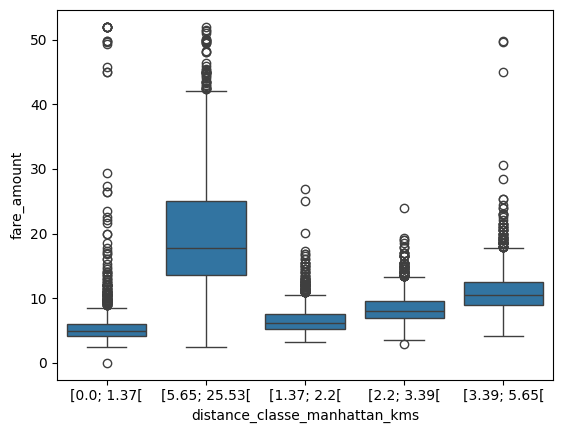

In [412]:
# fare_amount*distance_classe_manhattan_kms
sb.boxplot(x='distance_classe_manhattan_kms', y='fare_amount', data=taxi_test)
plt.show()

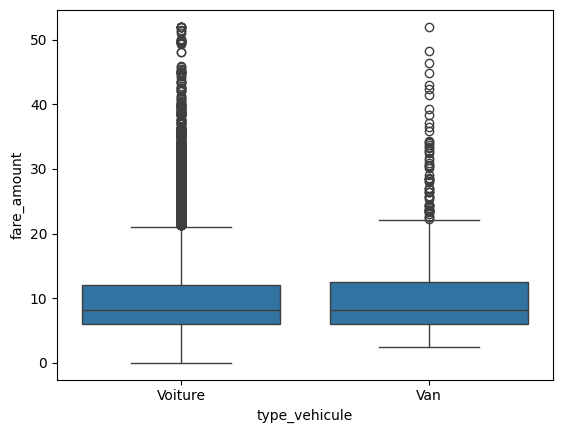

In [413]:
# fare_amount*type_vehicule
sb.boxplot(x='type_vehicule', y='fare_amount', data=taxi_test)
plt.show()

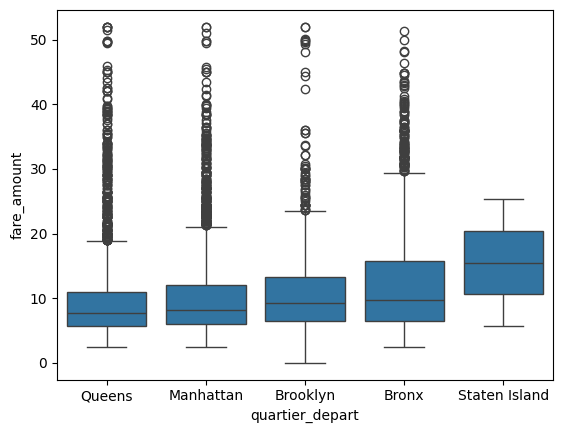

In [414]:
# fare_amount*quartier_depart
sb.boxplot(x='quartier_depart', y='fare_amount', data=taxi_test)
plt.show()

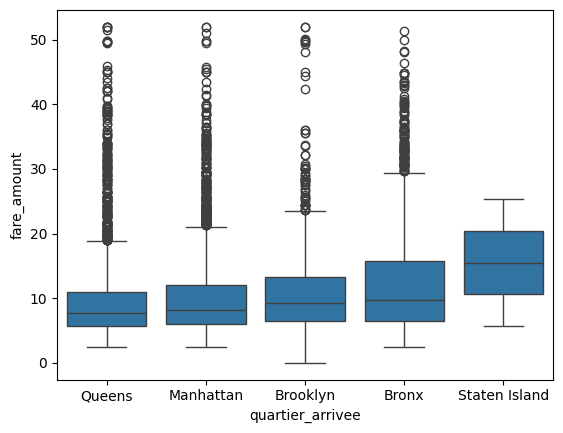

In [415]:
# fare_amount*quartier_arrivee
sb.boxplot(x='quartier_arrivee', y='fare_amount', data=taxi_test)
plt.show()

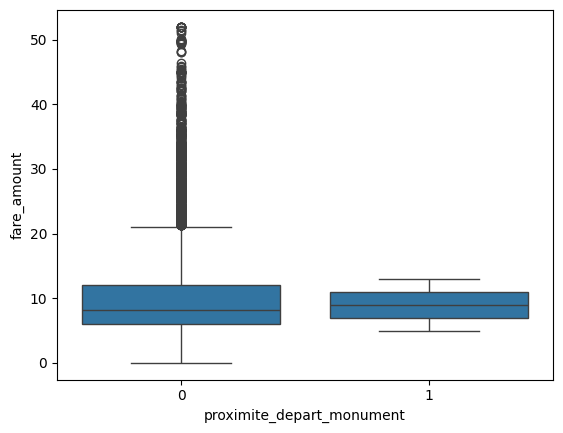

In [416]:
# fare_amount*proximite_depart_monument
sb.boxplot(x='proximite_depart_monument', y='fare_amount', data=taxi_test)
plt.show()

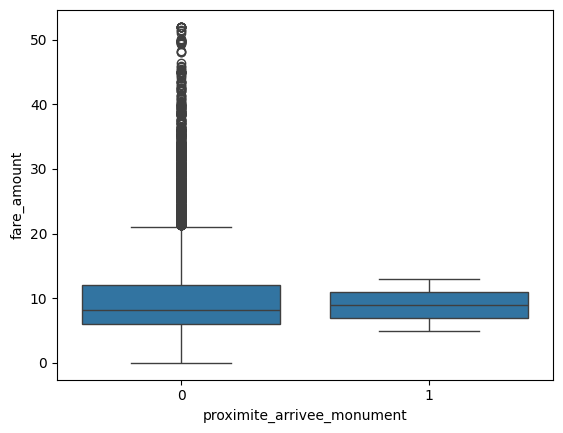

In [417]:
# fare_amount*proximite_arrivee_monument
sb.boxplot(x='proximite_arrivee_monument', y='fare_amount', data=taxi_test)
plt.show()

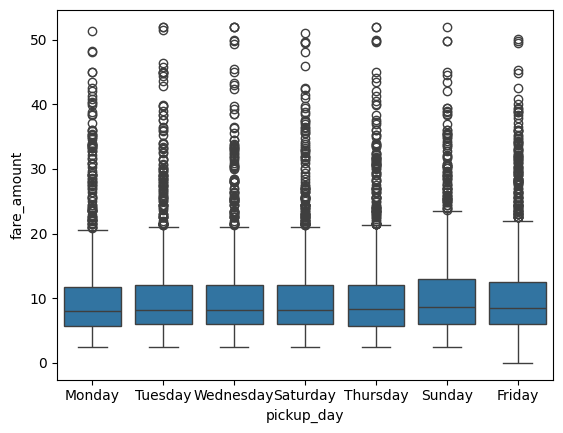

In [418]:
# fare_amount*pickup_day
sb.boxplot(x='pickup_day', y='fare_amount', data=taxi_test)
plt.show()

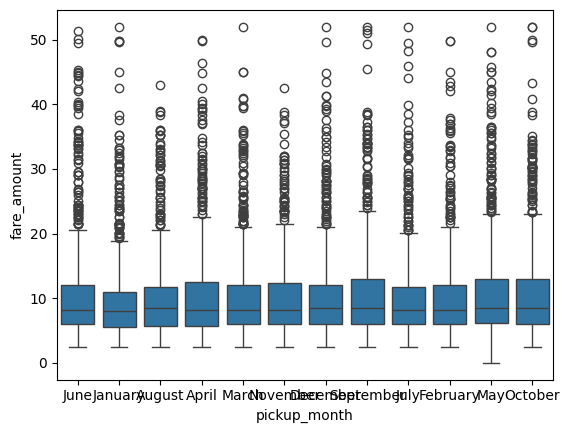

In [419]:
# fare_amount*pickup_month
sb.boxplot(x='pickup_month', y='fare_amount', data=taxi_test)
plt.show()

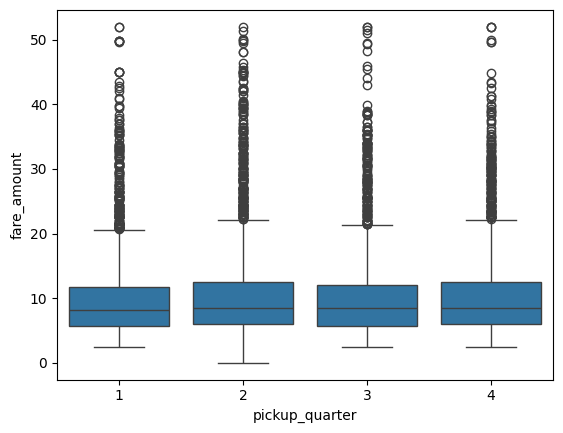

In [420]:
# fare_amount*pickup_quarter
sb.boxplot(x='pickup_quarter', y='fare_amount', data=taxi_test)
plt.show()

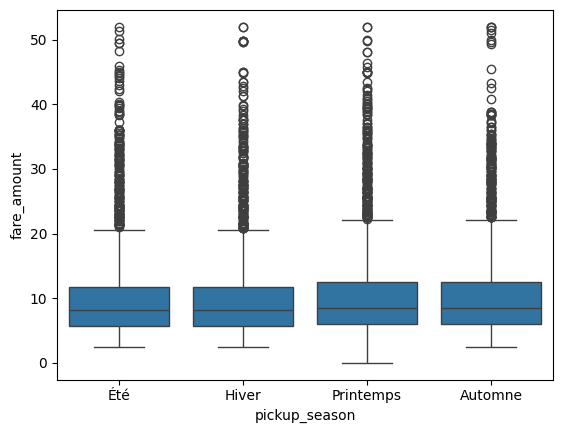

In [421]:
# fare_amount*pickup_season
sb.boxplot(x='pickup_season', y='fare_amount', data=taxi_test)
plt.show()

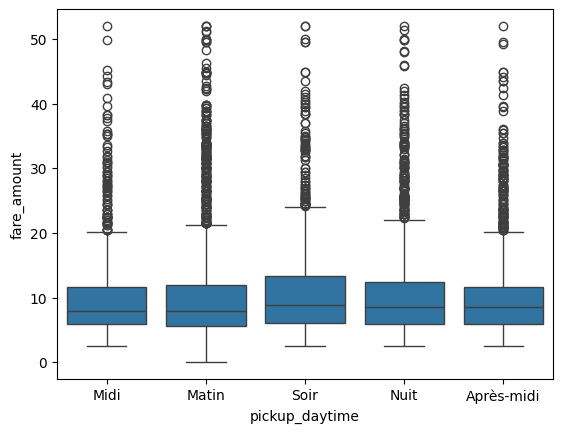

In [422]:
# fare_amount*pickup_daytime
sb.boxplot(x='pickup_daytime', y='fare_amount', data=taxi_test)
plt.show()

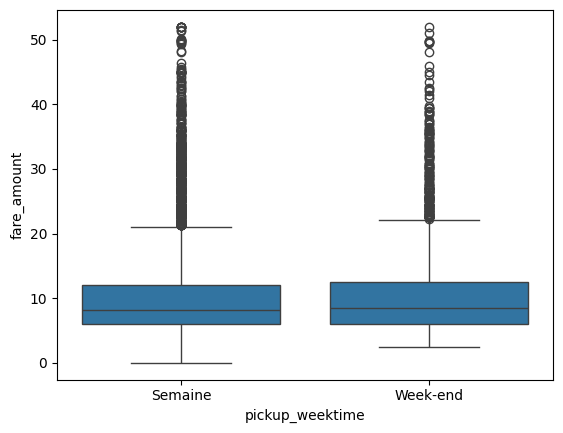

In [423]:
# fare_amount*pickup_weektime
sb.boxplot(x='pickup_weektime', y='fare_amount', data=taxi_test)
plt.show()

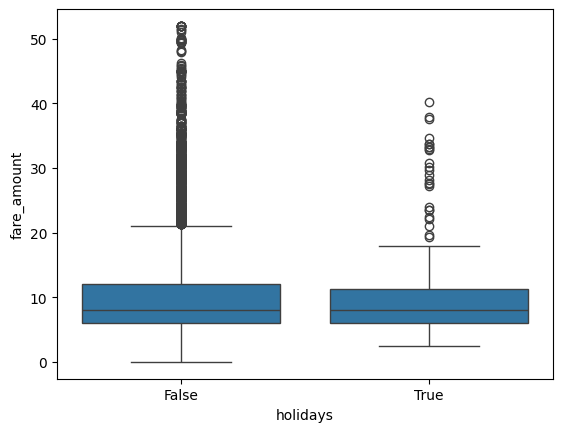

In [424]:
# fare_amount*holidays
sb.boxplot(x='holidays', y='fare_amount', data=taxi_test)
plt.show()

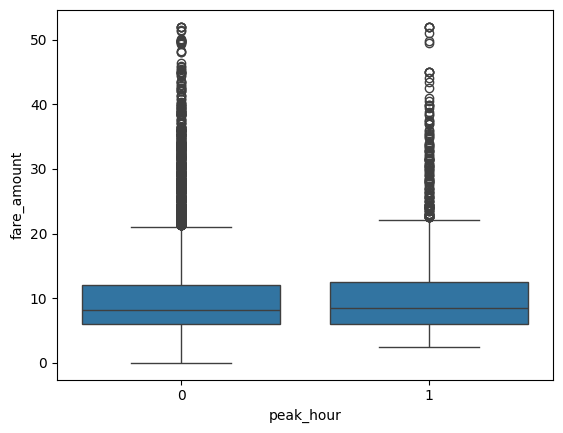

In [425]:
# fare_amount*peak_hour
sb.boxplot(x='peak_hour', y='fare_amount', data=taxi_test)
plt.show()

In [426]:
def summary_stats_grouped(taxi_test, quantitative_var, qualitative_var):
    # Calculer la moyenne groupée par la variable qualitative
    mean_by_group = taxi_test.groupby(qualitative_var)[quantitative_var].mean()

    # Calculer la médiane groupée par la variable qualitative
    median_by_group = taxi_test.groupby(qualitative_var)[quantitative_var].median()

    # Calculer les quartiles groupés par la variable qualitative
    quartiles_by_group = taxi_test.groupby(qualitative_var)[quantitative_var].quantile([0.25, 0.5, 0.75])

    # Calculer le minimum groupé par la variable qualitative
    min_by_group = taxi_test.groupby(qualitative_var)[quantitative_var].min()

    # Calculer le maximum groupé par la variable qualitative
    max_by_group = taxi_test.groupby(qualitative_var)[quantitative_var].max()

    # Retourner les résultats
    return mean_by_group, median_by_group, quartiles_by_group, min_by_group, max_by_group

mean_by_group, median_by_group, quartiles_by_group, min_by_group, max_by_group = summary_stats_grouped(taxi_test, 'fare_amount', 'distance_classe_manhattan_kms')

print("Moyenne par groupe:")
print(mean_by_group)

print("\nMédiane par groupe:")
print(median_by_group)

print("\nQuartiles par groupe:")
print(quartiles_by_group)

print("\nMinimum par groupe:")
print(min_by_group)

print("\nMaximum par groupe:")
print(max_by_group)

Moyenne par groupe:
distance_classe_manhattan_kms
[0.0; 1.37[       5.690749
[1.37; 2.2[       6.707392
[2.2; 3.39[       8.350562
[3.39; 5.65[     11.100958
[5.65; 25.53[    20.141660
Name: fare_amount, dtype: float64

Médiane par groupe:
distance_classe_manhattan_kms
[0.0; 1.37[       4.9
[1.37; 2.2[       6.1
[2.2; 3.39[       8.0
[3.39; 5.65[     10.5
[5.65; 25.53[    17.7
Name: fare_amount, dtype: float64

Quartiles par groupe:
distance_classe_manhattan_kms      
[0.0; 1.37[                    0.25     4.10
                               0.50     4.90
                               0.75     6.00
[1.37; 2.2[                    0.25     5.30
                               0.50     6.10
                               0.75     7.50
[2.2; 3.39[                    0.25     6.90
                               0.50     8.00
                               0.75     9.50
[3.39; 5.65[                   0.25     8.90
                               0.50    10.50
                               0

In [427]:
mean_by_group, median_by_group, quartiles_by_group, min_by_group, max_by_group = summary_stats_grouped(taxi_test, 'fare_amount', 'type_vehicule')

print("Moyenne par groupe:")
print(mean_by_group)

print("\nMédiane par groupe:")
print(median_by_group)

print("\nQuartiles par groupe:")
print(quartiles_by_group)

print("\nMinimum par groupe:")
print(min_by_group)

print("\nMaximum par groupe:")
print(max_by_group)

Moyenne par groupe:
type_vehicule
Van        10.488618
Voiture    10.390271
Name: fare_amount, dtype: float64

Médiane par groupe:
type_vehicule
Van        8.1
Voiture    8.1
Name: fare_amount, dtype: float64

Quartiles par groupe:
type_vehicule      
Van            0.25     6.0
               0.50     8.1
               0.75    12.5
Voiture        0.25     6.0
               0.50     8.1
               0.75    12.1
Name: fare_amount, dtype: float64

Minimum par groupe:
type_vehicule
Van        2.50
Voiture    0.01
Name: fare_amount, dtype: float64

Maximum par groupe:
type_vehicule
Van        52.0
Voiture    52.0
Name: fare_amount, dtype: float64


In [428]:
mean_by_group, median_by_group, quartiles_by_group, min_by_group, max_by_group = summary_stats_grouped(taxi_test, 'fare_amount', 'quartier_depart')

print("Moyenne par groupe:")
print(mean_by_group)

print("\nMédiane par groupe:")
print(median_by_group)

print("\nQuartiles par groupe:")
print(quartiles_by_group)

print("\nMinimum par groupe:")
print(min_by_group)

print("\nMaximum par groupe:")
print(max_by_group)

Moyenne par groupe:
quartier_depart
Bronx            13.067957
Brooklyn         11.120319
Manhattan         9.948164
Queens            9.732683
Staten Island    15.500000
Name: fare_amount, dtype: float64

Médiane par groupe:
quartier_depart
Bronx             9.7
Brooklyn          9.3
Manhattan         8.1
Queens            7.7
Staten Island    15.5
Name: fare_amount, dtype: float64

Quartiles par groupe:
quartier_depart      
Bronx            0.25     6.5
                 0.50     9.7
                 0.75    15.7
Brooklyn         0.25     6.5
                 0.50     9.3
                 0.75    13.3
Manhattan        0.25     6.0
                 0.50     8.1
                 0.75    12.0
Queens           0.25     5.7
                 0.50     7.7
                 0.75    11.0
Staten Island    0.25    10.6
                 0.50    15.5
                 0.75    20.4
Name: fare_amount, dtype: float64

Minimum par groupe:
quartier_depart
Bronx            2.50
Brooklyn         0.01
Manh

In [429]:
mean_by_group, median_by_group, quartiles_by_group, min_by_group, max_by_group = summary_stats_grouped(taxi_test, 'fare_amount', 'quartier_arrivee')

print("Moyenne par groupe:")
print(mean_by_group)

print("\nMédiane par groupe:")
print(median_by_group)

print("\nQuartiles par groupe:")
print(quartiles_by_group)

print("\nMinimum par groupe:")
print(min_by_group)

print("\nMaximum par groupe:")
print(max_by_group)

Moyenne par groupe:
quartier_arrivee
Bronx            13.067957
Brooklyn         11.120319
Manhattan         9.948164
Queens            9.732683
Staten Island    15.500000
Name: fare_amount, dtype: float64

Médiane par groupe:
quartier_arrivee
Bronx             9.7
Brooklyn          9.3
Manhattan         8.1
Queens            7.7
Staten Island    15.5
Name: fare_amount, dtype: float64

Quartiles par groupe:
quartier_arrivee      
Bronx             0.25     6.5
                  0.50     9.7
                  0.75    15.7
Brooklyn          0.25     6.5
                  0.50     9.3
                  0.75    13.3
Manhattan         0.25     6.0
                  0.50     8.1
                  0.75    12.0
Queens            0.25     5.7
                  0.50     7.7
                  0.75    11.0
Staten Island     0.25    10.6
                  0.50    15.5
                  0.75    20.4
Name: fare_amount, dtype: float64

Minimum par groupe:
quartier_arrivee
Bronx            2.50
Brookly

In [430]:
mean_by_group, median_by_group, quartiles_by_group, min_by_group, max_by_group = summary_stats_grouped(taxi_test, 'fare_amount', 'proximite_depart_monument')

print("Moyenne par groupe:")
print(mean_by_group)

print("\nMédiane par groupe:")
print(median_by_group)

print("\nQuartiles par groupe:")
print(quartiles_by_group)

print("\nMinimum par groupe:")
print(min_by_group)

print("\nMaximum par groupe:")
print(max_by_group)

Moyenne par groupe:
proximite_depart_monument
0    10.39908
1     9.00000
Name: fare_amount, dtype: float64

Médiane par groupe:
proximite_depart_monument
0    8.1
1    9.0
Name: fare_amount, dtype: float64

Quartiles par groupe:
proximite_depart_monument      
0                          0.25     6.0
                           0.50     8.1
                           0.75    12.1
1                          0.25     7.0
                           0.50     9.0
                           0.75    11.0
Name: fare_amount, dtype: float64

Minimum par groupe:
proximite_depart_monument
0    0.01
1    5.00
Name: fare_amount, dtype: float64

Maximum par groupe:
proximite_depart_monument
0    52.0
1    13.0
Name: fare_amount, dtype: float64


In [431]:
mean_by_group, median_by_group, quartiles_by_group, min_by_group, max_by_group = summary_stats_grouped(taxi_test, 'fare_amount', 'proximite_arrivee_monument')

print("Moyenne par groupe:")
print(mean_by_group)

print("\nMédiane par groupe:")
print(median_by_group)

print("\nQuartiles par groupe:")
print(quartiles_by_group)

print("\nMinimum par groupe:")
print(min_by_group)

print("\nMaximum par groupe:")
print(max_by_group)

Moyenne par groupe:
proximite_arrivee_monument
0    10.39908
1     9.00000
Name: fare_amount, dtype: float64

Médiane par groupe:
proximite_arrivee_monument
0    8.1
1    9.0
Name: fare_amount, dtype: float64

Quartiles par groupe:
proximite_arrivee_monument      
0                           0.25     6.0
                            0.50     8.1
                            0.75    12.1
1                           0.25     7.0
                            0.50     9.0
                            0.75    11.0
Name: fare_amount, dtype: float64

Minimum par groupe:
proximite_arrivee_monument
0    0.01
1    5.00
Name: fare_amount, dtype: float64

Maximum par groupe:
proximite_arrivee_monument
0    52.0
1    13.0
Name: fare_amount, dtype: float64


In [432]:
mean_by_group, median_by_group, quartiles_by_group, min_by_group, max_by_group = summary_stats_grouped(taxi_test, 'fare_amount', 'pickup_day')

print("Moyenne par groupe:")
print(mean_by_group)

print("\nMédiane par groupe:")
print(median_by_group)

print("\nQuartiles par groupe:")
print(quartiles_by_group)

print("\nMinimum par groupe:")
print(min_by_group)

print("\nMaximum par groupe:")
print(max_by_group)

Moyenne par groupe:
pickup_day
Friday       10.632100
Monday       10.166190
Saturday     10.306382
Sunday       10.923367
Thursday     10.298531
Tuesday      10.288992
Wednesday    10.263168
Name: fare_amount, dtype: float64

Médiane par groupe:
pickup_day
Friday       8.5
Monday       8.0
Saturday     8.1
Sunday       8.7
Thursday     8.4
Tuesday      8.1
Wednesday    8.1
Name: fare_amount, dtype: float64

Quartiles par groupe:
pickup_day      
Friday      0.25     6.00
            0.50     8.50
            0.75    12.50
Monday      0.25     5.70
            0.50     8.00
            0.75    11.70
Saturday    0.25     6.00
            0.50     8.10
            0.75    12.10
Sunday      0.25     6.00
            0.50     8.70
            0.75    13.00
Thursday    0.25     5.70
            0.50     8.40
            0.75    12.00
Tuesday     0.25     6.00
            0.50     8.10
            0.75    12.05
Wednesday   0.25     6.00
            0.50     8.10
            0.75    12.00
Nam

In [433]:
mean_by_group, median_by_group, quartiles_by_group, min_by_group, max_by_group = summary_stats_grouped(taxi_test, 'fare_amount', 'pickup_month')

print("Moyenne par groupe:")
print(mean_by_group)

print("\nMédiane par groupe:")
print(median_by_group)

print("\nQuartiles par groupe:")
print(quartiles_by_group)

print("\nMinimum par groupe:")
print(min_by_group)

print("\nMaximum par groupe:")
print(max_by_group)

Moyenne par groupe:
pickup_month
April        10.454822
August       10.170551
December     10.603148
February     10.137666
January       9.664806
July         10.164295
June         10.475898
March        10.149519
May          10.813945
November     10.298184
October      10.945125
September    10.998632
Name: fare_amount, dtype: float64

Médiane par groupe:
pickup_month
April        8.1
August       8.5
December     8.5
February     8.1
January      8.0
July         8.1
June         8.1
March        8.1
May          8.5
November     8.1
October      8.5
September    8.5
Name: fare_amount, dtype: float64

Quartiles par groupe:
pickup_month      
April         0.25     5.7
              0.50     8.1
              0.75    12.5
August        0.25     5.7
              0.50     8.5
              0.75    11.7
December      0.25     6.0
              0.50     8.5
              0.75    12.1
February      0.25     6.0
              0.50     8.1
              0.75    12.1
January       0.25 

In [434]:
mean_by_group, median_by_group, quartiles_by_group, min_by_group, max_by_group = summary_stats_grouped(taxi_test, 'fare_amount', 'pickup_quarter')

print("Moyenne par groupe:")
print(mean_by_group)

print("\nMédiane par groupe:")
print(median_by_group)

print("\nQuartiles par groupe:")
print(quartiles_by_group)

print("\nMinimum par groupe:")
print(min_by_group)

print("\nMaximum par groupe:")
print(max_by_group)

Moyenne par groupe:
pickup_quarter
1     9.979890
2    10.587439
3    10.447033
4    10.625219
Name: fare_amount, dtype: float64

Médiane par groupe:
pickup_quarter
1    8.1
2    8.5
3    8.5
4    8.5
Name: fare_amount, dtype: float64

Quartiles par groupe:
pickup_quarter      
1               0.25     5.7
                0.50     8.1
                0.75    11.7
2               0.25     6.0
                0.50     8.5
                0.75    12.5
3               0.25     5.7
                0.50     8.5
                0.75    12.0
4               0.25     6.0
                0.50     8.5
                0.75    12.5
Name: fare_amount, dtype: float64

Minimum par groupe:
pickup_quarter
1    2.50
2    0.01
3    2.50
4    2.50
Name: fare_amount, dtype: float64

Maximum par groupe:
pickup_quarter
1    52.0
2    52.0
3    52.0
4    52.0
Name: fare_amount, dtype: float64


In [435]:
mean_by_group, median_by_group, quartiles_by_group, min_by_group, max_by_group = summary_stats_grouped(taxi_test, 'fare_amount', 'pickup_season')

print("Moyenne par groupe:")
print(mean_by_group)

print("\nMédiane par groupe:")
print(median_by_group)

print("\nQuartiles par groupe:")
print(quartiles_by_group)

print("\nMinimum par groupe:")
print(min_by_group)

print("\nMaximum par groupe:")
print(max_by_group)

Moyenne par groupe:
pickup_season
Automne      10.754213
Hiver        10.099297
Printemps    10.474883
Été          10.290815
Name: fare_amount, dtype: float64

Médiane par groupe:
pickup_season
Automne      8.5
Hiver        8.1
Printemps    8.5
Été          8.1
Name: fare_amount, dtype: float64

Quartiles par groupe:
pickup_season      
Automne        0.25     6.0
               0.50     8.5
               0.75    12.5
Hiver          0.25     5.7
               0.50     8.1
               0.75    11.7
Printemps      0.25     6.0
               0.50     8.5
               0.75    12.5
Été            0.25     5.7
               0.50     8.1
               0.75    11.7
Name: fare_amount, dtype: float64

Minimum par groupe:
pickup_season
Automne      2.50
Hiver        2.50
Printemps    0.01
Été          2.50
Name: fare_amount, dtype: float64

Maximum par groupe:
pickup_season
Automne      52.0
Hiver        52.0
Printemps    52.0
Été          52.0
Name: fare_amount, dtype: float64


In [436]:
mean_by_group, median_by_group, quartiles_by_group, min_by_group, max_by_group = summary_stats_grouped(taxi_test, 'fare_amount', 'pickup_daytime')

print("Moyenne par groupe:")
print(mean_by_group)

print("\nMédiane par groupe:")
print(median_by_group)

print("\nQuartiles par groupe:")
print(quartiles_by_group)

print("\nMinimum par groupe:")
print(min_by_group)

print("\nMaximum par groupe:")
print(max_by_group)

Moyenne par groupe:
pickup_daytime
Après-midi     9.992550
Matin         10.325382
Midi          10.168495
Nuit          10.595421
Soir          11.180617
Name: fare_amount, dtype: float64

Médiane par groupe:
pickup_daytime
Après-midi    8.5
Matin         8.0
Midi          8.0
Nuit          8.5
Soir          8.9
Name: fare_amount, dtype: float64

Quartiles par groupe:
pickup_daytime      
Après-midi      0.25     6.0
                0.50     8.5
                0.75    11.7
Matin           0.25     5.7
                0.50     8.0
                0.75    12.0
Midi            0.25     6.0
                0.50     8.0
                0.75    11.7
Nuit            0.25     6.0
                0.50     8.5
                0.75    12.5
Soir            0.25     6.1
                0.50     8.9
                0.75    13.3
Name: fare_amount, dtype: float64

Minimum par groupe:
pickup_daytime
Après-midi    2.50
Matin         0.01
Midi          2.50
Nuit          2.50
Soir          2.50
Name: f

In [437]:
mean_by_group, median_by_group, quartiles_by_group, min_by_group, max_by_group = summary_stats_grouped(taxi_test, 'fare_amount', 'pickup_weektime')

print("Moyenne par groupe:")
print(mean_by_group)

print("\nMédiane par groupe:")
print(median_by_group)

print("\nQuartiles par groupe:")
print(quartiles_by_group)

print("\nMinimum par groupe:")
print(min_by_group)

print("\nMaximum par groupe:")
print(max_by_group)

Moyenne par groupe:
pickup_weektime
Semaine     10.338047
Week-end    10.564577
Name: fare_amount, dtype: float64

Médiane par groupe:
pickup_weektime
Semaine     8.1
Week-end    8.5
Name: fare_amount, dtype: float64

Quartiles par groupe:
pickup_weektime      
Semaine          0.25     6.0
                 0.50     8.1
                 0.75    12.1
Week-end         0.25     6.0
                 0.50     8.5
                 0.75    12.5
Name: fare_amount, dtype: float64

Minimum par groupe:
pickup_weektime
Semaine     0.01
Week-end    2.50
Name: fare_amount, dtype: float64

Maximum par groupe:
pickup_weektime
Semaine     52.0
Week-end    52.0
Name: fare_amount, dtype: float64


In [438]:
mean_by_group, median_by_group, quartiles_by_group, min_by_group, max_by_group = summary_stats_grouped(taxi_test, 'fare_amount', 'holidays')

print("Moyenne par groupe:")
print(mean_by_group)

print("\nMédiane par groupe:")
print(median_by_group)

print("\nQuartiles par groupe:")
print(quartiles_by_group)

print("\nMinimum par groupe:")
print(min_by_group)

print("\nMaximum par groupe:")
print(max_by_group)

Moyenne par groupe:
holidays
False    10.410465
True     10.028912
Name: fare_amount, dtype: float64

Médiane par groupe:
holidays
False    8.1
True     8.0
Name: fare_amount, dtype: float64

Quartiles par groupe:
holidays      
False     0.25     6.000
          0.50     8.100
          0.75    12.100
True      0.25     6.000
          0.50     8.000
          0.75    11.225
Name: fare_amount, dtype: float64

Minimum par groupe:
holidays
False    0.01
True     2.50
Name: fare_amount, dtype: float64

Maximum par groupe:
holidays
False    52.00
True     40.27
Name: fare_amount, dtype: float64


In [439]:
mean_by_group, median_by_group, quartiles_by_group, min_by_group, max_by_group = summary_stats_grouped(taxi_test, 'fare_amount', 'peak_hour')

print("Moyenne par groupe:")
print(mean_by_group)

print("\nMédiane par groupe:")
print(median_by_group)

print("\nQuartiles par groupe:")
print(quartiles_by_group)

print("\nMinimum par groupe:")
print(min_by_group)

print("\nMaximum par groupe:")
print(max_by_group)

Moyenne par groupe:
peak_hour
0    10.370520
1    10.506441
Name: fare_amount, dtype: float64

Médiane par groupe:
peak_hour
0    8.1
1    8.5
Name: fare_amount, dtype: float64

Quartiles par groupe:
peak_hour      
0          0.25     6.0
           0.50     8.1
           0.75    12.1
1          0.25     6.0
           0.50     8.5
           0.75    12.5
Name: fare_amount, dtype: float64

Minimum par groupe:
peak_hour
0    0.01
1    2.50
Name: fare_amount, dtype: float64

Maximum par groupe:
peak_hour
0    52.0
1    52.0
Name: fare_amount, dtype: float64


# Statistiques univariées

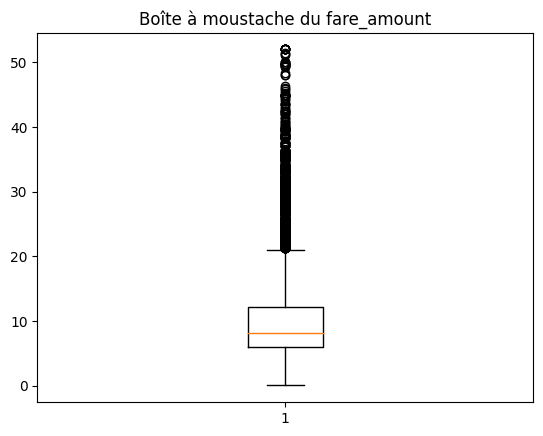

In [440]:
plt.boxplot(taxi_test.fare_amount)
plt.title("Boîte à moustache du fare_amount")
plt.show()

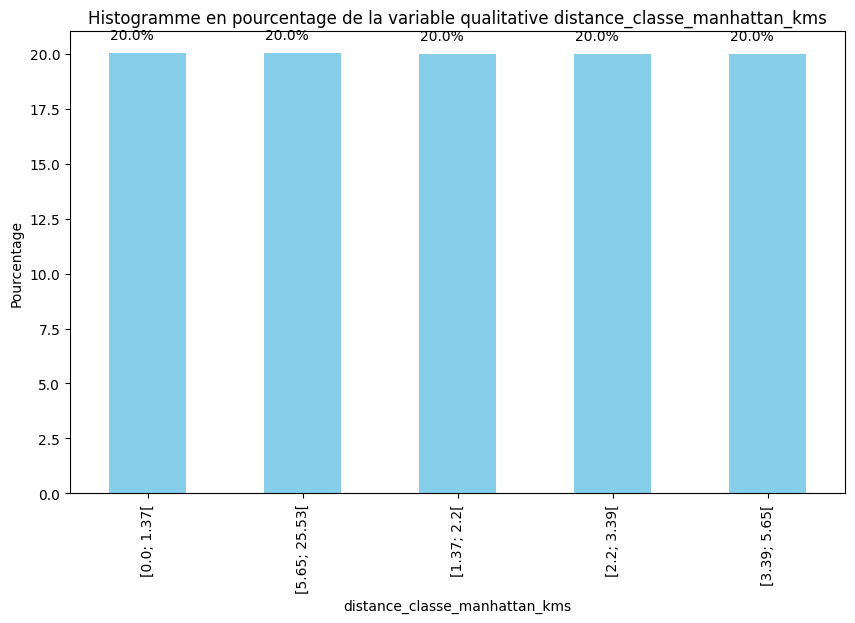

In [441]:
variable_quali = 'distance_classe_manhattan_kms'

# Calculer les pourcentages
percentages = (taxi_test[variable_quali].value_counts() / len(taxi_test)) * 100

# Créer l'histogramme en pourcentage
plt.figure(figsize=(10, 6))  # Réglez la taille de la figure selon vos préférences
bars = percentages.plot(kind='bar', color='skyblue')

# Ajouter des étiquettes et un titre
plt.xlabel(variable_quali)
plt.ylabel('Pourcentage')
plt.title(f'Histogramme en pourcentage de la variable qualitative {variable_quali}')

# Ajouter les pourcentages sur les barres
for bar, percentage in zip(bars.patches, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, f'{percentage:.1f}%', ha='center', va='bottom', color='black')

# Afficher l'histogramme
plt.show()

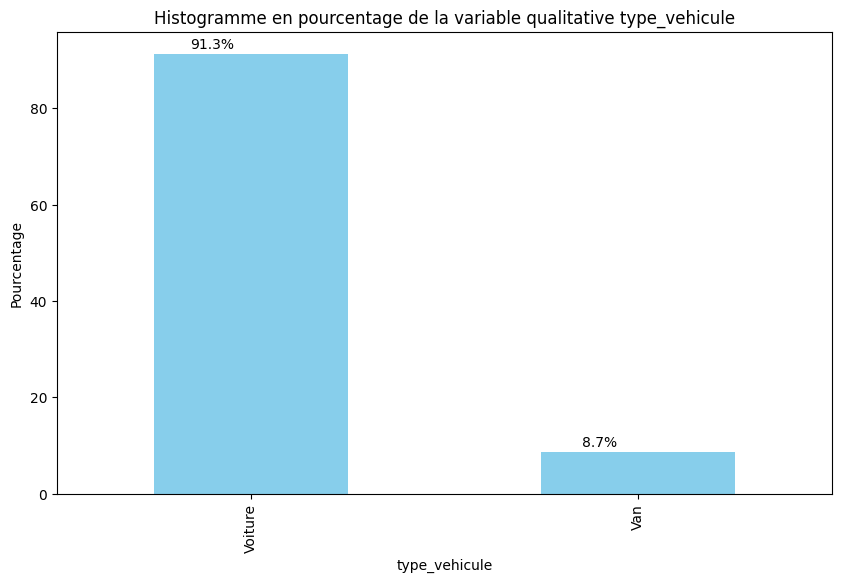

In [442]:
variable_quali = 'type_vehicule'

# Calculer les pourcentages
percentages = (taxi_test[variable_quali].value_counts() / len(taxi_test)) * 100

# Créer l'histogramme en pourcentage
plt.figure(figsize=(10, 6))  # Réglez la taille de la figure selon vos préférences
bars = percentages.plot(kind='bar', color='skyblue')

# Ajouter des étiquettes et un titre
plt.xlabel(variable_quali)
plt.ylabel('Pourcentage')
plt.title(f'Histogramme en pourcentage de la variable qualitative {variable_quali}')

# Ajouter les pourcentages sur les barres
for bar, percentage in zip(bars.patches, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, f'{percentage:.1f}%', ha='center', va='bottom', color='black')

# Afficher l'histogramme
plt.show()

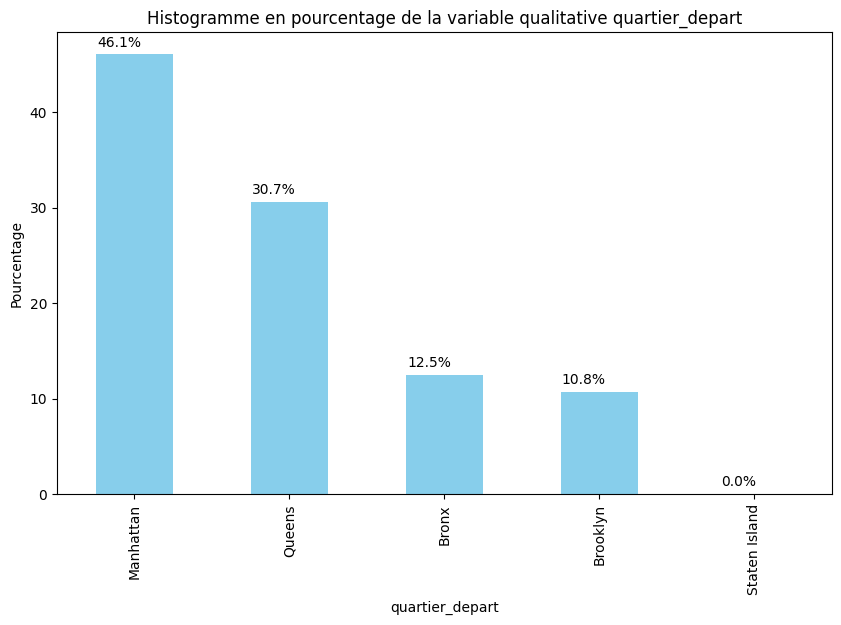

In [443]:
variable_quali = 'quartier_depart'

# Calculer les pourcentages
percentages = (taxi_test[variable_quali].value_counts() / len(taxi_test)) * 100

# Créer l'histogramme en pourcentage
plt.figure(figsize=(10, 6))  # Réglez la taille de la figure selon vos préférences
bars = percentages.plot(kind='bar', color='skyblue')

# Ajouter des étiquettes et un titre
plt.xlabel(variable_quali)
plt.ylabel('Pourcentage')
plt.title(f'Histogramme en pourcentage de la variable qualitative {variable_quali}')

# Ajouter les pourcentages sur les barres
for bar, percentage in zip(bars.patches, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, f'{percentage:.1f}%', ha='center', va='bottom', color='black')

# Afficher l'histogramme
plt.show()

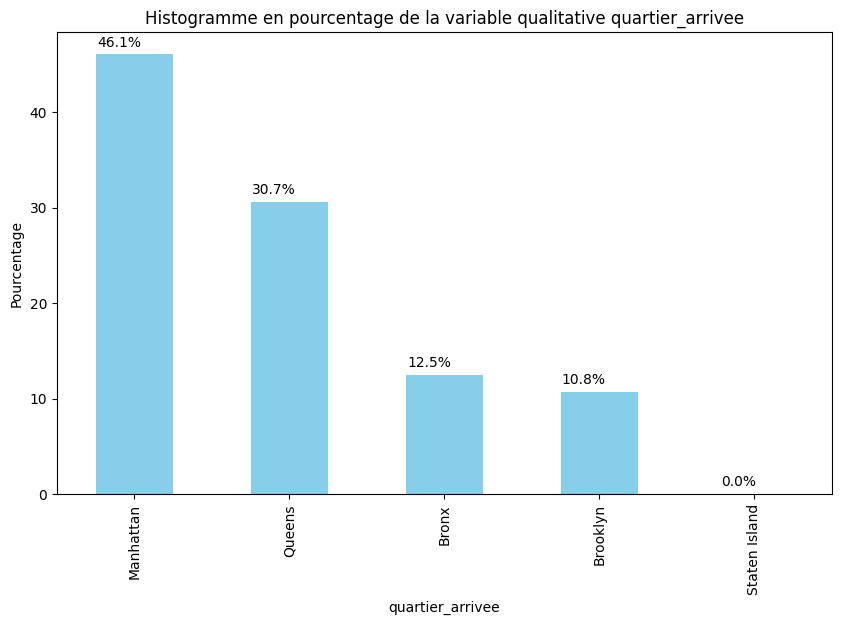

In [444]:
variable_quali = 'quartier_arrivee'

# Calculer les pourcentages
percentages = (taxi_test[variable_quali].value_counts() / len(taxi_test)) * 100

# Créer l'histogramme en pourcentage
plt.figure(figsize=(10, 6))  # Réglez la taille de la figure selon vos préférences
bars = percentages.plot(kind='bar', color='skyblue')

# Ajouter des étiquettes et un titre
plt.xlabel(variable_quali)
plt.ylabel('Pourcentage')
plt.title(f'Histogramme en pourcentage de la variable qualitative {variable_quali}')

# Ajouter les pourcentages sur les barres
for bar, percentage in zip(bars.patches, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, f'{percentage:.1f}%', ha='center', va='bottom', color='black')

# Afficher l'histogramme
plt.show()

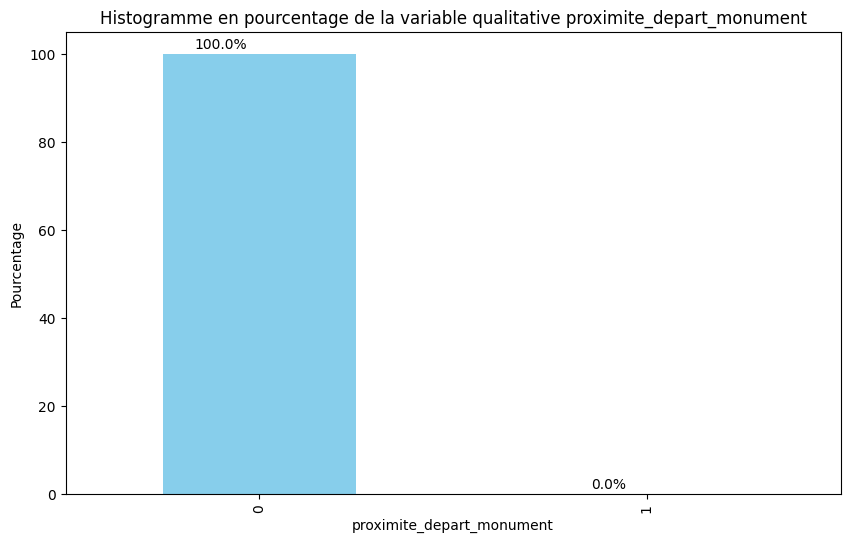

In [445]:
variable_quali = 'proximite_depart_monument'

# Calculer les pourcentages
percentages = (taxi_test[variable_quali].value_counts() / len(taxi_test)) * 100

# Créer l'histogramme en pourcentage
plt.figure(figsize=(10, 6))  # Réglez la taille de la figure selon vos préférences
bars = percentages.plot(kind='bar', color='skyblue')

# Ajouter des étiquettes et un titre
plt.xlabel(variable_quali)
plt.ylabel('Pourcentage')
plt.title(f'Histogramme en pourcentage de la variable qualitative {variable_quali}')

# Ajouter les pourcentages sur les barres
for bar, percentage in zip(bars.patches, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, f'{percentage:.1f}%', ha='center', va='bottom', color='black')

# Afficher l'histogramme
plt.show()

On n'est pas à 0 % mais presque

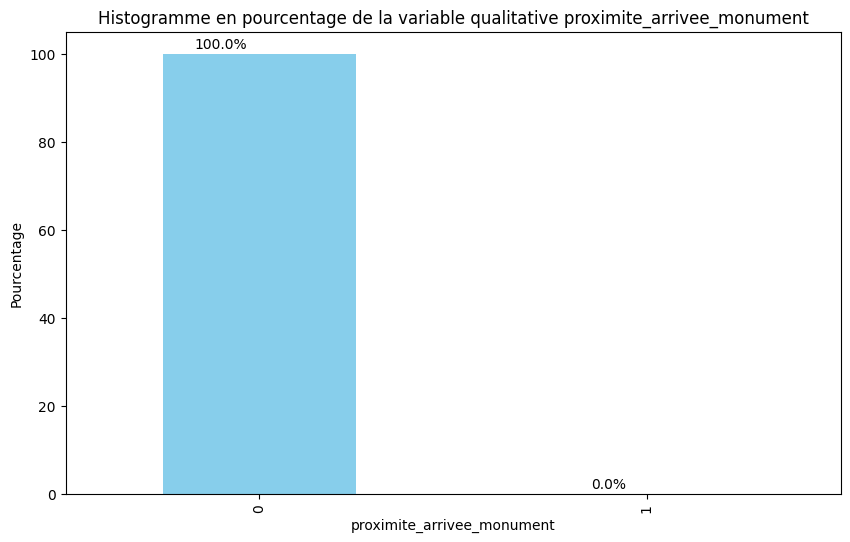

In [446]:
variable_quali = 'proximite_arrivee_monument'

# Calculer les pourcentages
percentages = (taxi_test[variable_quali].value_counts() / len(taxi_test)) * 100

# Créer l'histogramme en pourcentage
plt.figure(figsize=(10, 6))  # Réglez la taille de la figure selon vos préférences
bars = percentages.plot(kind='bar', color='skyblue')

# Ajouter des étiquettes et un titre
plt.xlabel(variable_quali)
plt.ylabel('Pourcentage')
plt.title(f'Histogramme en pourcentage de la variable qualitative {variable_quali}')

# Ajouter les pourcentages sur les barres
for bar, percentage in zip(bars.patches, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, f'{percentage:.1f}%', ha='center', va='bottom', color='black')

# Afficher l'histogramme
plt.show()

On n'est pas à 0 % mais presque

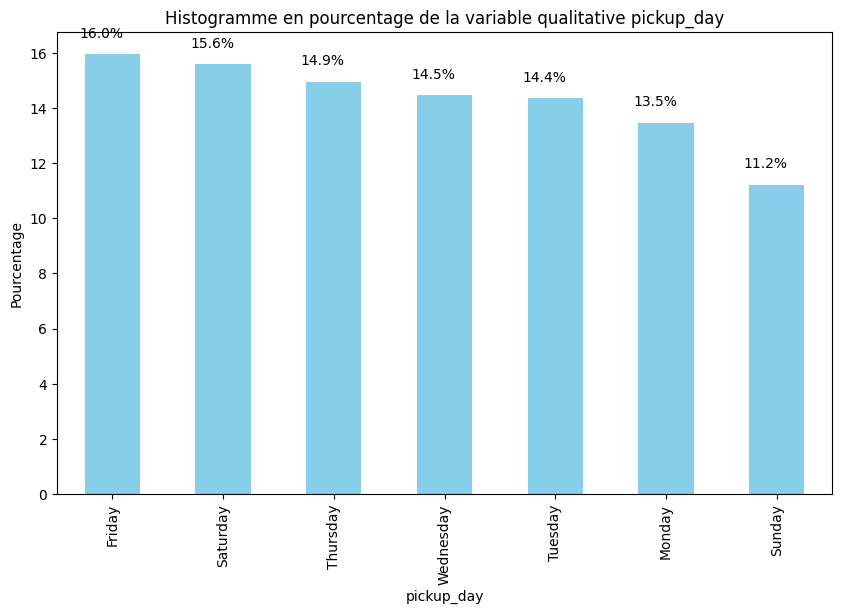

In [447]:
variable_quali = 'pickup_day'

# Calculer les pourcentages
percentages = (taxi_test[variable_quali].value_counts() / len(taxi_test)) * 100

# Créer l'histogramme en pourcentage
plt.figure(figsize=(10, 6))  # Réglez la taille de la figure selon vos préférences
bars = percentages.plot(kind='bar', color='skyblue')

# Ajouter des étiquettes et un titre
plt.xlabel(variable_quali)
plt.ylabel('Pourcentage')
plt.title(f'Histogramme en pourcentage de la variable qualitative {variable_quali}')

# Ajouter les pourcentages sur les barres
for bar, percentage in zip(bars.patches, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, f'{percentage:.1f}%', ha='center', va='bottom', color='black')

# Afficher l'histogramme
plt.show()

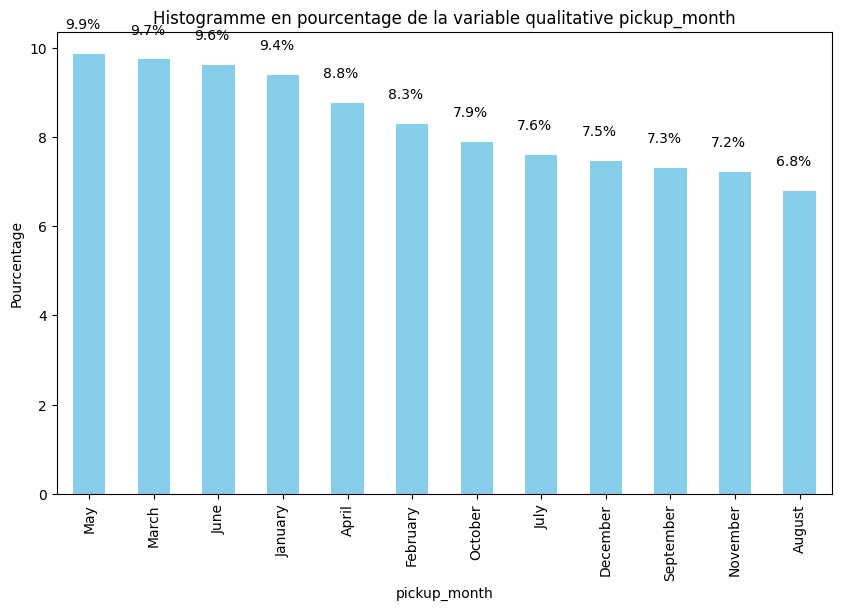

In [448]:
variable_quali = 'pickup_month'

# Calculer les pourcentages
percentages = (taxi_test[variable_quali].value_counts() / len(taxi_test)) * 100

# Créer l'histogramme en pourcentage
plt.figure(figsize=(10, 6))  # Réglez la taille de la figure selon vos préférences
bars = percentages.plot(kind='bar', color='skyblue')

# Ajouter des étiquettes et un titre
plt.xlabel(variable_quali)
plt.ylabel('Pourcentage')
plt.title(f'Histogramme en pourcentage de la variable qualitative {variable_quali}')

# Ajouter les pourcentages sur les barres
for bar, percentage in zip(bars.patches, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, f'{percentage:.1f}%', ha='center', va='bottom', color='black')

# Afficher l'histogramme
plt.show()

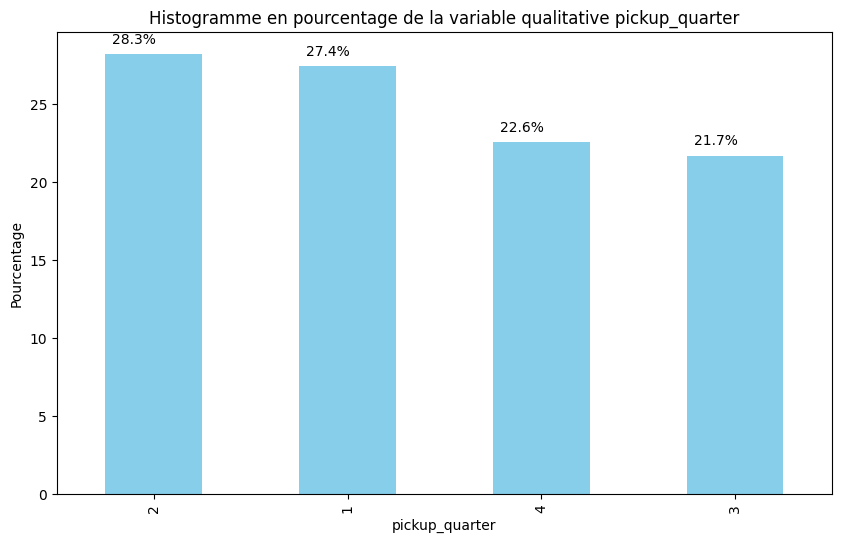

In [449]:
variable_quali = 'pickup_quarter'

# Calculer les pourcentages
percentages = (taxi_test[variable_quali].value_counts() / len(taxi_test)) * 100

# Créer l'histogramme en pourcentage
plt.figure(figsize=(10, 6))  # Réglez la taille de la figure selon vos préférences
bars = percentages.plot(kind='bar', color='skyblue')

# Ajouter des étiquettes et un titre
plt.xlabel(variable_quali)
plt.ylabel('Pourcentage')
plt.title(f'Histogramme en pourcentage de la variable qualitative {variable_quali}')

# Ajouter les pourcentages sur les barres
for bar, percentage in zip(bars.patches, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, f'{percentage:.1f}%', ha='center', va='bottom', color='black')

# Afficher l'histogramme
plt.show()

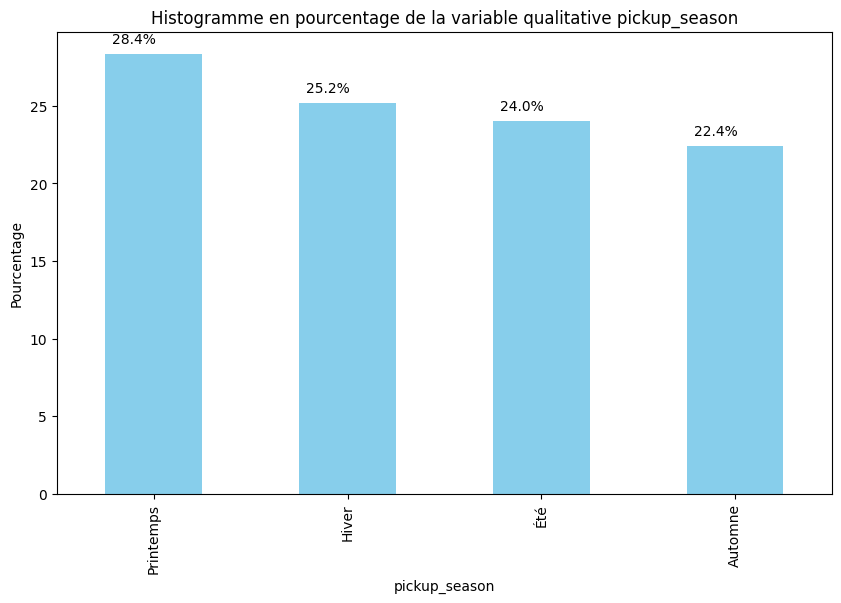

In [450]:
variable_quali = 'pickup_season'

# Calculer les pourcentages
percentages = (taxi_test[variable_quali].value_counts() / len(taxi_test)) * 100

# Créer l'histogramme en pourcentage
plt.figure(figsize=(10, 6))  # Réglez la taille de la figure selon vos préférences
bars = percentages.plot(kind='bar', color='skyblue')

# Ajouter des étiquettes et un titre
plt.xlabel(variable_quali)
plt.ylabel('Pourcentage')
plt.title(f'Histogramme en pourcentage de la variable qualitative {variable_quali}')

# Ajouter les pourcentages sur les barres
for bar, percentage in zip(bars.patches, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, f'{percentage:.1f}%', ha='center', va='bottom', color='black')

# Afficher l'histogramme
plt.show()

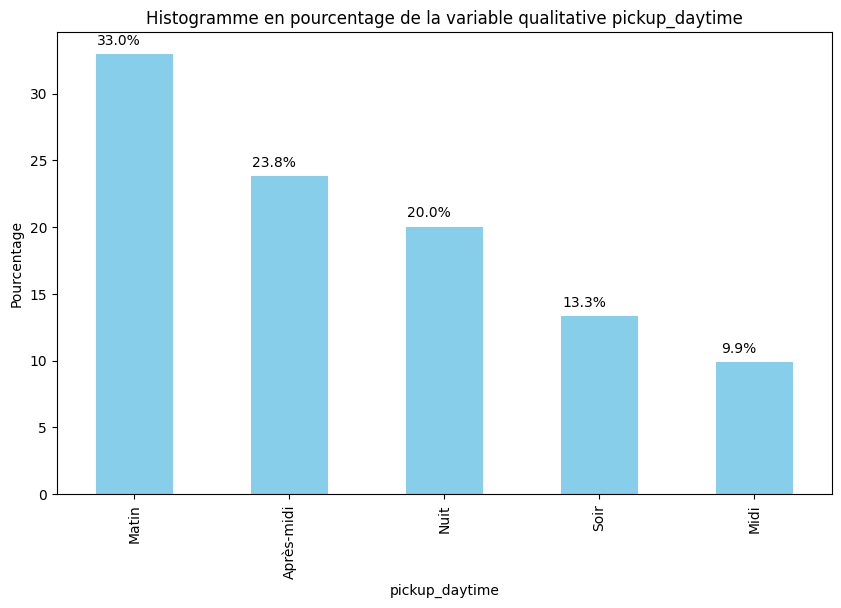

In [451]:
variable_quali = 'pickup_daytime'

# Calculer les pourcentages
percentages = (taxi_test[variable_quali].value_counts() / len(taxi_test)) * 100

# Créer l'histogramme en pourcentage
plt.figure(figsize=(10, 6))  # Réglez la taille de la figure selon vos préférences
bars = percentages.plot(kind='bar', color='skyblue')

# Ajouter des étiquettes et un titre
plt.xlabel(variable_quali)
plt.ylabel('Pourcentage')
plt.title(f'Histogramme en pourcentage de la variable qualitative {variable_quali}')

# Ajouter les pourcentages sur les barres
for bar, percentage in zip(bars.patches, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, f'{percentage:.1f}%', ha='center', va='bottom', color='black')

# Afficher l'histogramme
plt.show()

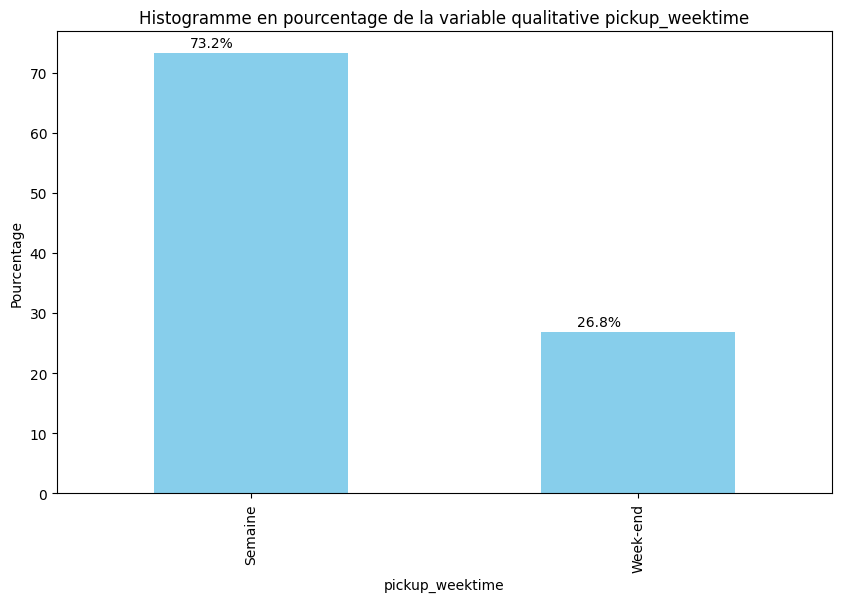

In [452]:
variable_quali = 'pickup_weektime'

# Calculer les pourcentages
percentages = (taxi_test[variable_quali].value_counts() / len(taxi_test)) * 100

# Créer l'histogramme en pourcentage
plt.figure(figsize=(10, 6))  # Réglez la taille de la figure selon vos préférences
bars = percentages.plot(kind='bar', color='skyblue')

# Ajouter des étiquettes et un titre
plt.xlabel(variable_quali)
plt.ylabel('Pourcentage')
plt.title(f'Histogramme en pourcentage de la variable qualitative {variable_quali}')

# Ajouter les pourcentages sur les barres
for bar, percentage in zip(bars.patches, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, f'{percentage:.1f}%', ha='center', va='bottom', color='black')

# Afficher l'histogramme
plt.show()

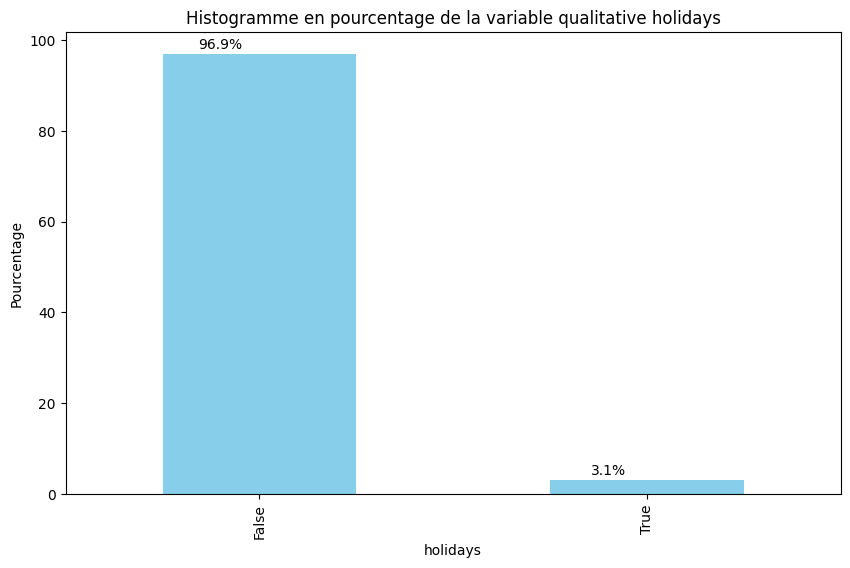

In [453]:
variable_quali = 'holidays'

# Calculer les pourcentages
percentages = (taxi_test[variable_quali].value_counts() / len(taxi_test)) * 100

# Créer l'histogramme en pourcentage
plt.figure(figsize=(10, 6))  # Réglez la taille de la figure selon vos préférences
bars = percentages.plot(kind='bar', color='skyblue')

# Ajouter des étiquettes et un titre
plt.xlabel(variable_quali)
plt.ylabel('Pourcentage')
plt.title(f'Histogramme en pourcentage de la variable qualitative {variable_quali}')

# Ajouter les pourcentages sur les barres
for bar, percentage in zip(bars.patches, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, f'{percentage:.1f}%', ha='center', va='bottom', color='black')

# Afficher l'histogramme
plt.show()

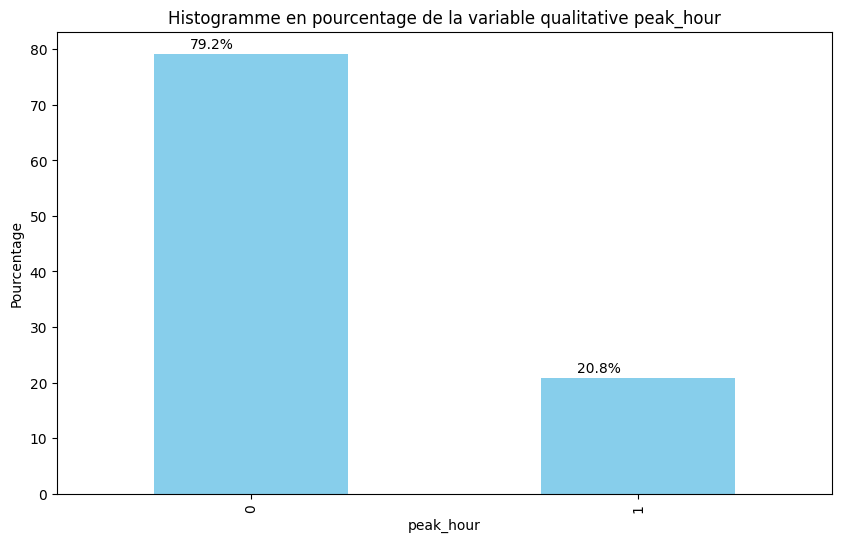

In [454]:
variable_quali = 'peak_hour'

# Calculer les pourcentages
percentages = (taxi_test[variable_quali].value_counts() / len(taxi_test)) * 100

# Créer l'histogramme en pourcentage
plt.figure(figsize=(10, 6))  # Réglez la taille de la figure selon vos préférences
bars = percentages.plot(kind='bar', color='skyblue')

# Ajouter des étiquettes et un titre
plt.xlabel(variable_quali)
plt.ylabel('Pourcentage')
plt.title(f'Histogramme en pourcentage de la variable qualitative {variable_quali}')

# Ajouter les pourcentages sur les barres
for bar, percentage in zip(bars.patches, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, f'{percentage:.1f}%', ha='center', va='bottom', color='black')

# Afficher l'histogramme
plt.show()

# Transformation en dummies

In [455]:
# Transformation en dummies
#taxi_test_dummies = pd.get_dummies(taxi_test, columns=['distance_classe_manhattan_kms',	'type_vehicule',	'quartier_depart',	'quartier_arrivee',	'proximite_depart_monument',	'proximite_arrivee_monument',	'pickup_day',	'pickup_month',	'pickup_quarter',	'pickup_season',	'pickup_daytime',	'pickup_weektime', 'holidays',	'peak_hour'], drop_first=True)
#taxi_test_dummies.head(50)

In [456]:
variable_quali = 'proximite_arrivee_monument'

# Compter les occurrences de chaque modalité
modalite_counts = taxi_test[variable_quali].value_counts()

# Afficher les résultats
print(modalite_counts)

0    9605
1       2
Name: proximite_arrivee_monument, dtype: int64


In [457]:
#dimensions
print("\n", taxi_test.shape[0], " individus et ", taxi_test.shape[1], " variables.")


 9607  individus et  19  variables.


In [460]:
taxi_test.head(50)

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance_classe_manhattan_kms,type_vehicule,quartier_depart,quartier_arrivee,proximite_depart_monument,proximite_arrivee_monument,pickup_day,pickup_month,pickup_quarter,pickup_season,pickup_daytime,pickup_weektime,holidays,peak_hour
0,4.50,-73.844311,40.721319,-73.841610,40.712278,[0.0; 1.37[,Voiture,Queens,Queens,0,0,Monday,June,2,Été,Midi,Semaine,False,0
1,16.90,-74.016048,40.711303,-73.979268,40.782004,[5.65; 25.53[,Voiture,Manhattan,Manhattan,0,0,Tuesday,January,1,Hiver,Matin,Semaine,False,0
2,5.70,-73.982738,40.761270,-73.991242,40.750562,[1.37; 2.2[,Voiture,Manhattan,Manhattan,0,0,Wednesday,August,3,Été,Soir,Semaine,False,0
3,7.70,-73.987130,40.733143,-73.991567,40.758092,[2.2; 3.39[,Voiture,Manhattan,Manhattan,0,0,Saturday,April,2,Printemps,Nuit,Week-end,False,0
4,5.30,-73.968095,40.768008,-73.956655,40.783762,[2.2; 3.39[,Voiture,Queens,Queens,0,0,Tuesday,March,1,Printemps,Nuit,Semaine,False,0
5,12.10,-74.000964,40.731630,-73.972892,40.758233,[3.39; 5.65[,Voiture,Manhattan,Manhattan,0,0,Thursday,January,1,Hiver,Nuit,Semaine,False,0
6,7.50,-73.980002,40.751662,-73.973802,40.764842,[1.37; 2.2[,Voiture,Queens,Queens,0,0,Tuesday,November,4,Automne,Après-midi,Semaine,False,0
7,16.50,-73.951300,40.774138,-73.990095,40.751048,[5.65; 25.53[,Voiture,Brooklyn,Brooklyn,0,0,Wednesday,January,1,Hiver,Midi,Semaine,False,0
8,9.00,-74.006462,40.726713,-73.993078,40.731628,[1.37; 2.2[,Voiture,Manhattan,Manhattan,0,0,Monday,December,4,Hiver,Matin,Semaine,False,1
9,8.90,-73.980658,40.733873,-73.991540,40.758138,[3.39; 5.65[,Voiture,Queens,Queens,0,0,Tuesday,September,3,Automne,Nuit,Semaine,False,0
